# 04 SER

---
## 0. Setup

In [1]:
import numpy as np
np.set_printoptions(precision=3)  # 数値桁数を指定．
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-colorblind')
plt.style.use('seaborn-whitegrid')

import importlib
import itertools

import sys
sys.path.append('../../RLPack')
sys.path.append('../')

---
## 1. Environment

In [2]:
import Env_Reserve
importlib.reload(Env_Reserve)

<module 'Env_Reserve' from '/media/deepstation/strage01/Actuary/2019/20191102_Reserve_SER/Env_Reserve.py'>

In [3]:
cashflow = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, -10])
interest = 0.01
hurdle = 0.05
initial_cash = 15
bankrupt_penalty = -50
bankrupt_info = False

env = Env_Reserve.Environment(cashflow=cashflow, 
                              interest=interest, hurdle=hurdle, 
                              initial_cash=initial_cash, bankrupt_penalty=bankrupt_penalty, 
                              bankrupt_info=bankrupt_info, 
                              n_agents=64)

---
## 2. Normal

In [4]:
env = Env_Reserve.Environment(cashflow=cashflow, 
                              interest=interest, hurdle=hurdle, 
                              initial_cash=initial_cash, bankrupt_penalty=bankrupt_penalty, 
                              bankrupt_info=bankrupt_info, 
                              n_agents=64)

n_trials = 5
n_steps = 10000

df = pd.DataFrame()

---
### DQN

/home/deepstation/.pyenv/versions/anaconda3-5.0.1/envs/ForChainer/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
W1108 00:20:24.534040 140141868304192 deprecation_wrapper.py:119] From /home/deepstation/.pyenv/versions/anaconda3-5.0.1/envs/ForChainer/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1108 00:20:24.534808 140141868304192 deprecation_wrapper.py:119] From /home/deepstation/.pyenv/versions/anaconda3-5.0.1/envs/ForChainer/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1108 00:20:24.537752 

lr=0.001, eps=0.5, boltzmann=False
start testing... :  2019-11-08 00:20:24.660072
start trial 1/5 trial...


W1108 00:20:24.961043 140141868304192 deprecation_wrapper.py:119] From /home/deepstation/.pyenv/versions/anaconda3-5.0.1/envs/ForChainer/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

  0%|          | 0/10000 [00:00<?, ?it/s]

start trial 2/5 trial...


  0%|          | 0/10000 [00:00<?, ?it/s]

start trial 3/5 trial...


100%|██████████| 10000/10000 [01:05<00:00, 153.54it/s]


start trial 4/5 trial...


100%|██████████| 10000/10000 [01:10<00:00, 130.00it/s]


start trial 5/5 trial...


100%|██████████| 10000/10000 [01:13<00:00, 136.55it/s]


end testing... :  2019-11-08 00:25:56.287101
loss and reward history


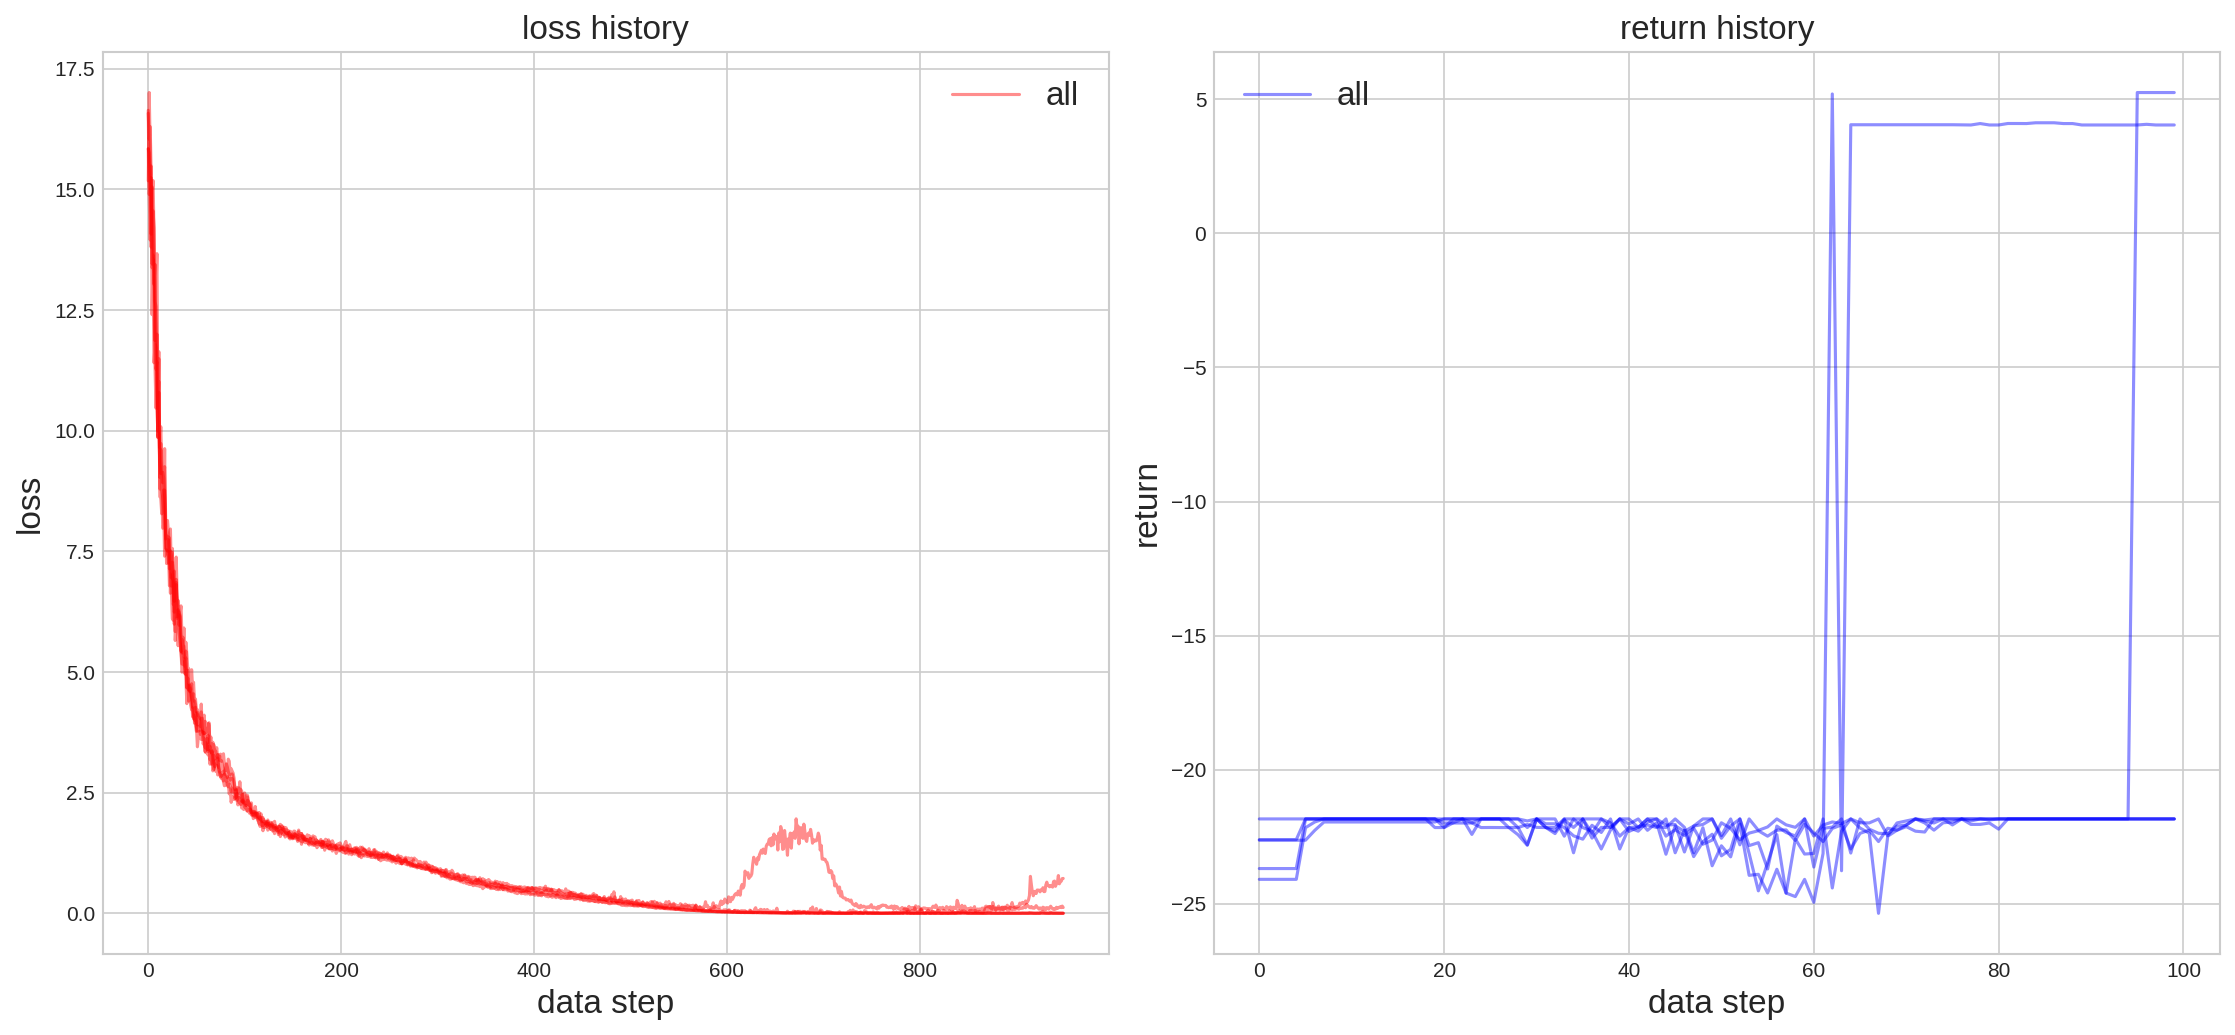

acquired action
action =  [0 0 0 0 0 0 0 0 0 0]
action =  [1 1 1 1 1 1 1 1 1 1]
action =  [16 16 16 16 16 16 16 16 16 16]
action =  [9 9 9 9 9 9 9 9 9 9]
action =  [10 10 10 10 10 10 10 10 10 10]
action =  [10 10 10 10 10 10 10 10 10 10]
action =  [18 18 18 18 18 18 18 18 18 18]
action =  [18 18 18 18 18 18 18 18 18 18]
action =  [10 10 10 10 10 10 10 10 10 10]
action =  [6 6 6 6 6 6 6 6 6 6]
return [-21.835 -21.835 -21.835 -21.835 -21.835 -21.835 -21.835 -21.835 -21.835
 -21.835]
param distribution in model


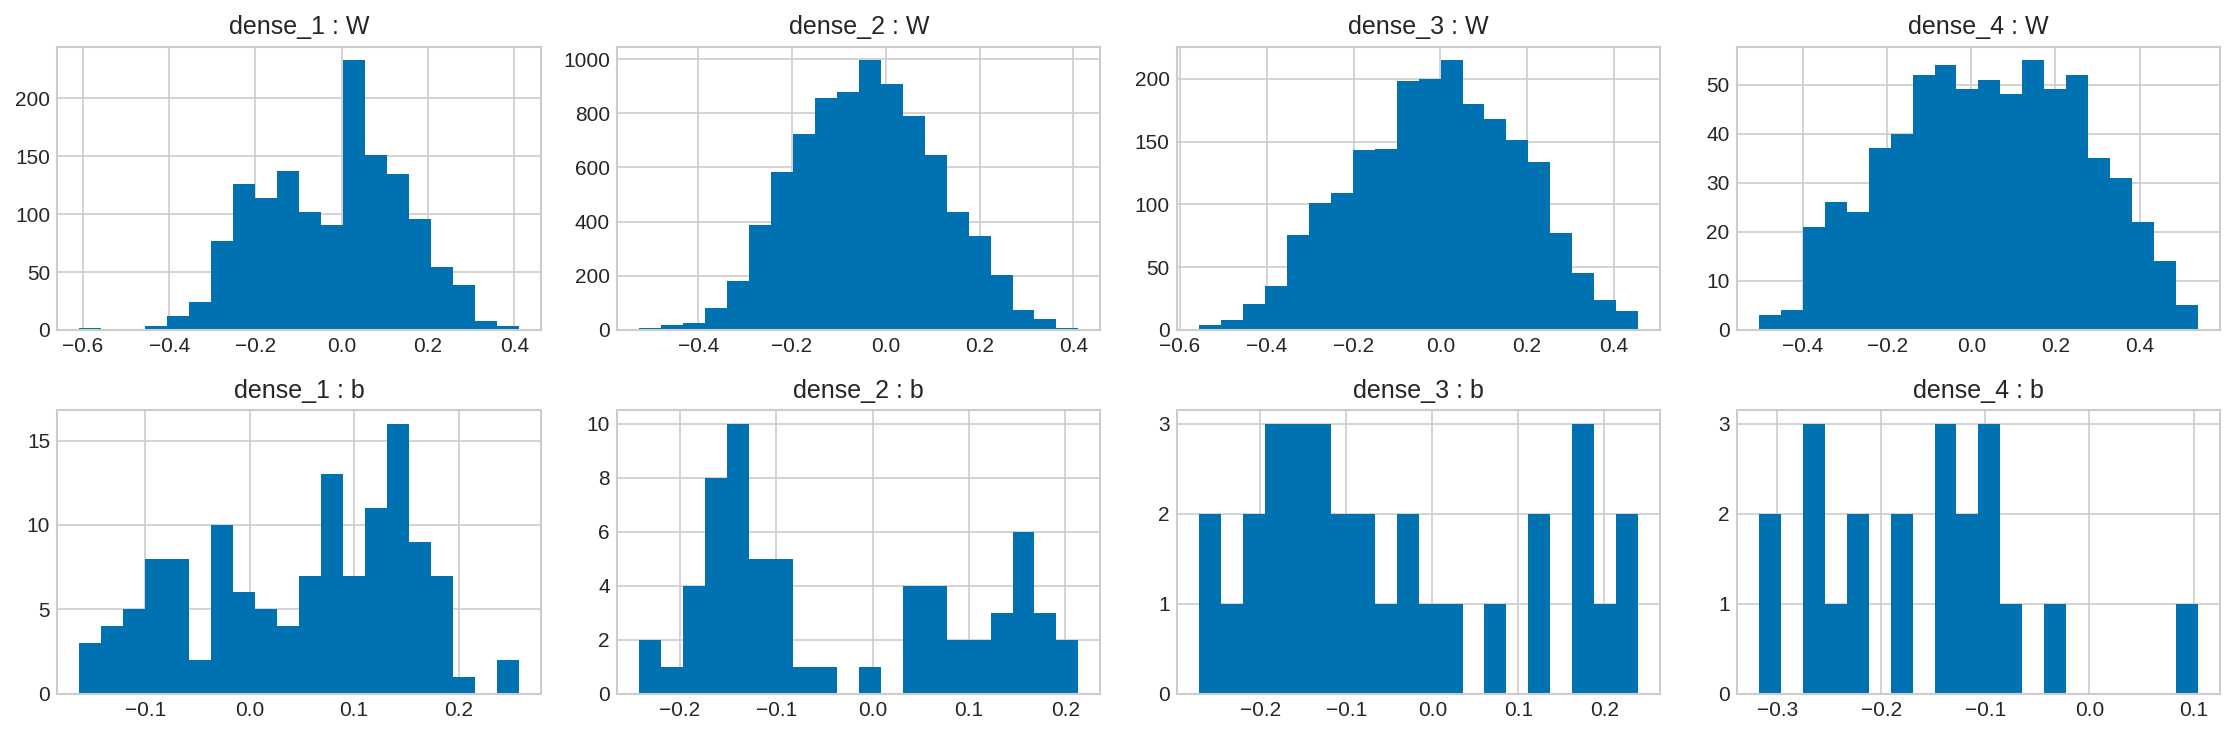

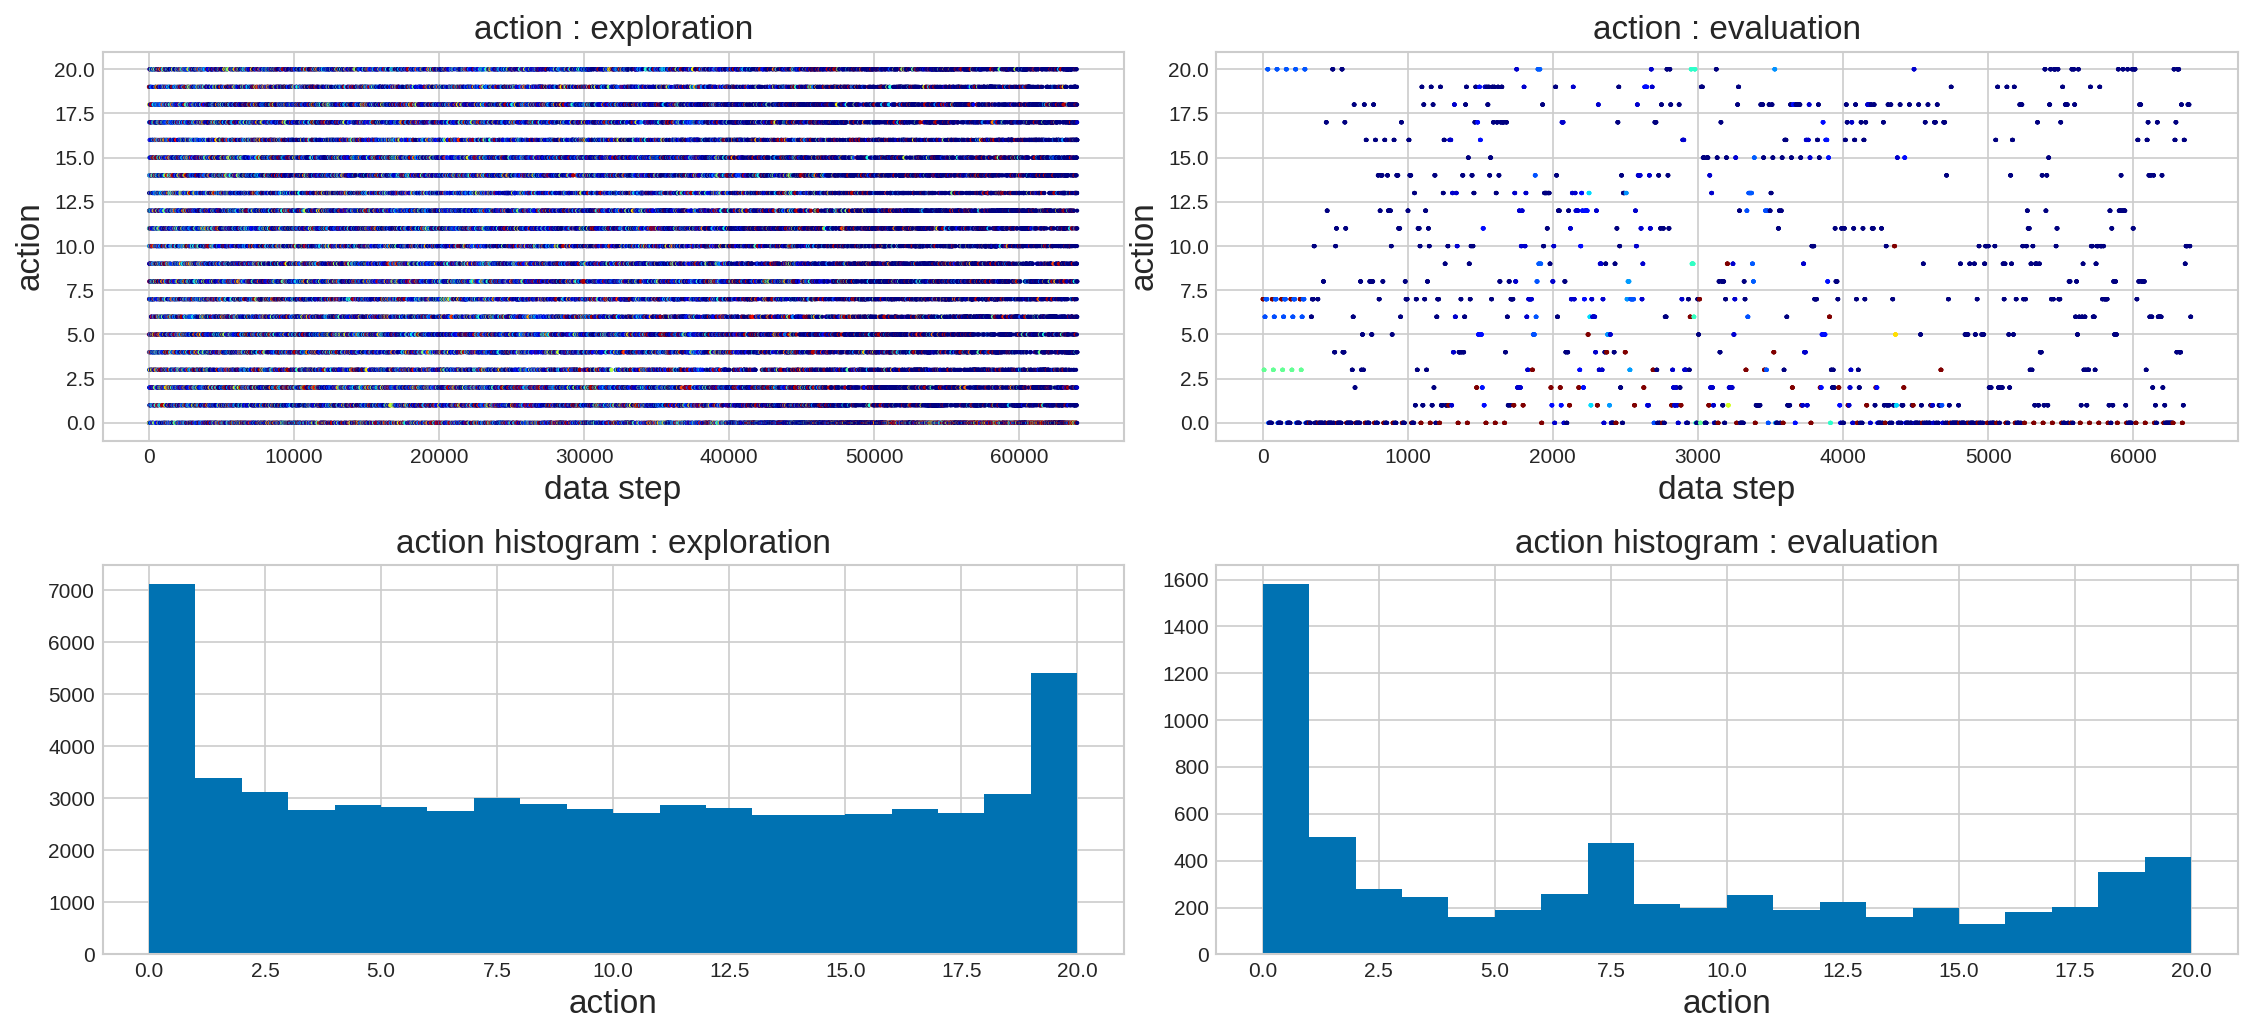

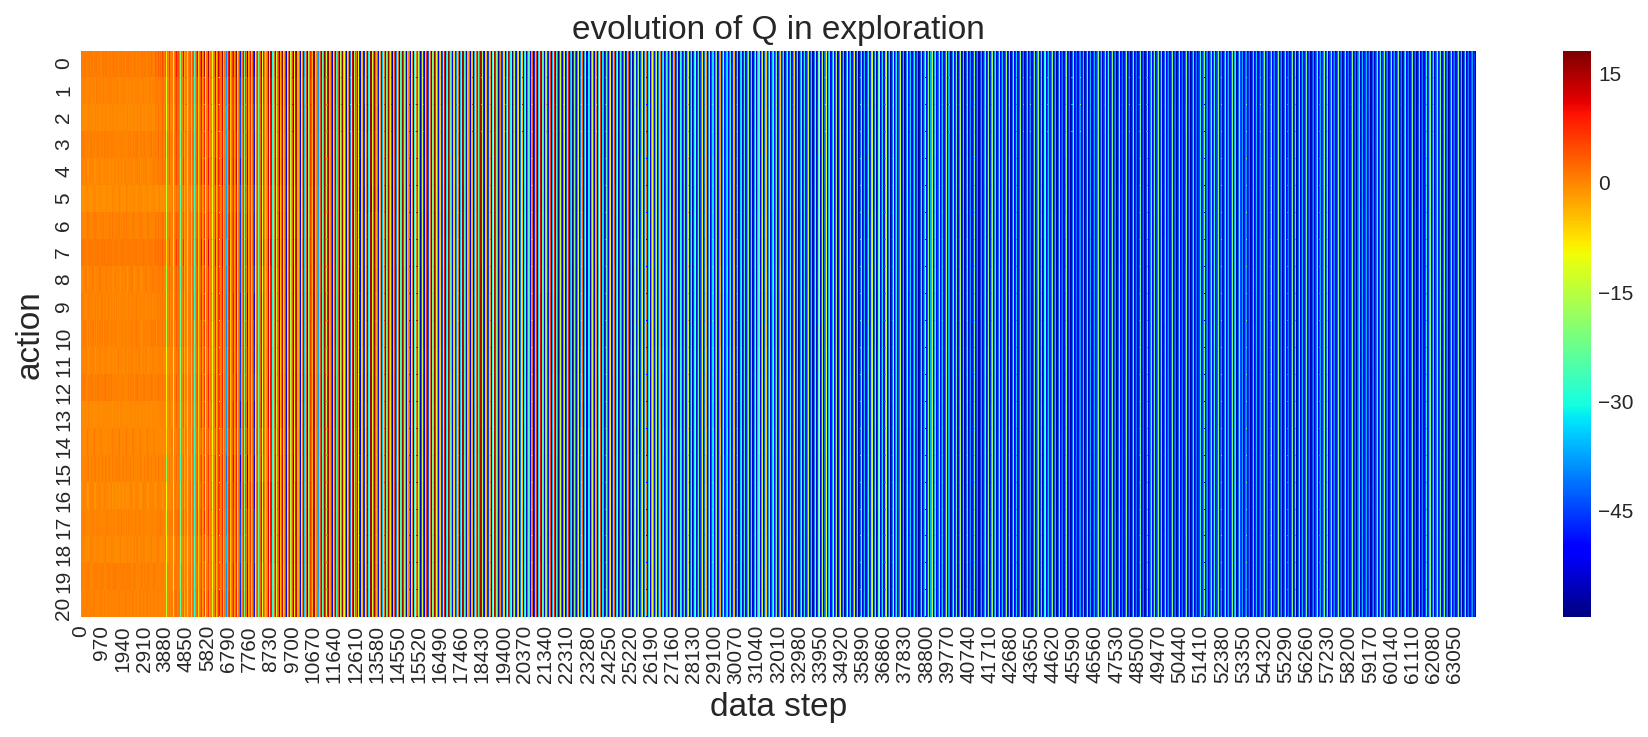

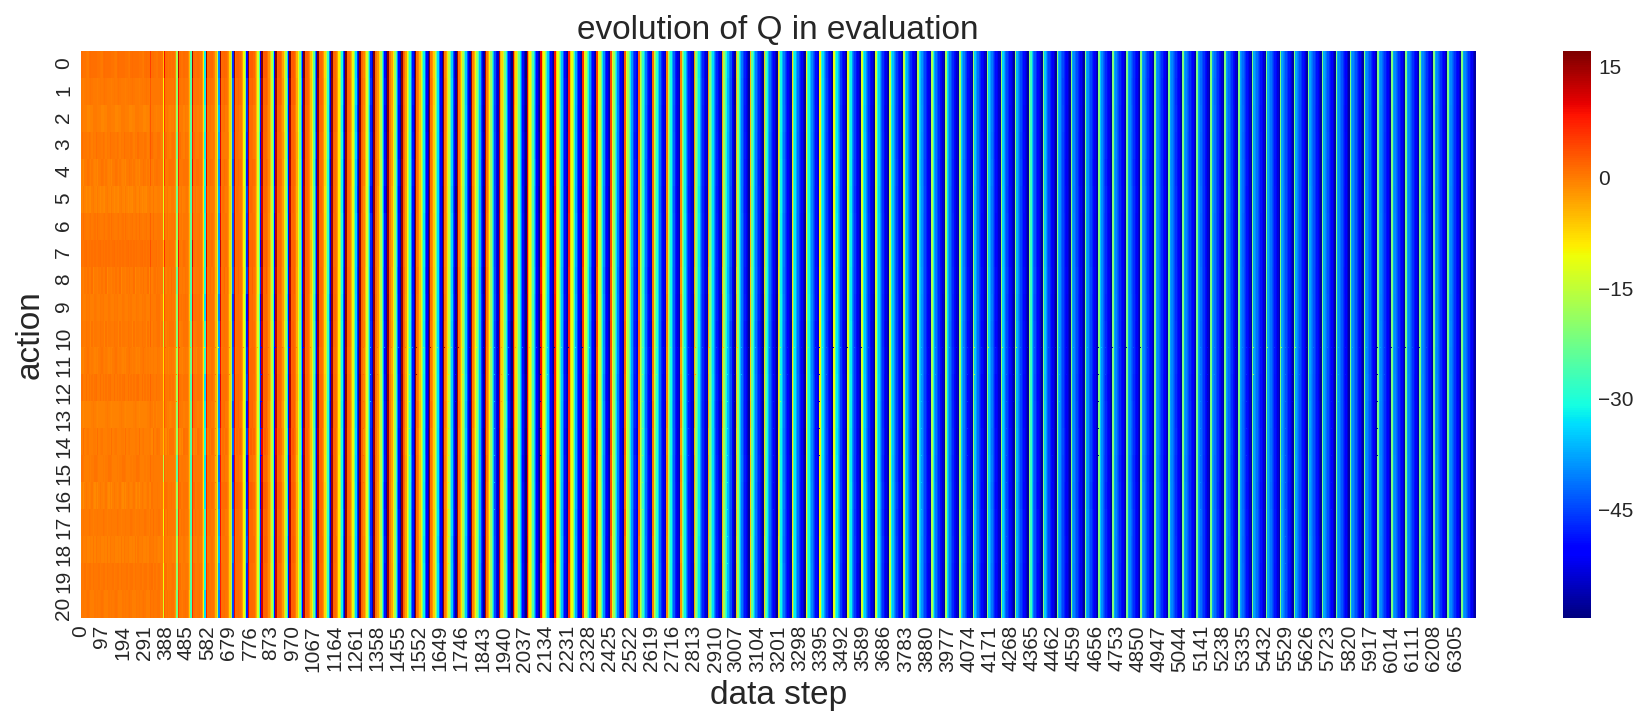

bankrupt=347992, total=352064, ratio=0.9884


In [5]:
import DQN
import importlib
importlib.reload(DQN)  # original DRL code
from keras import optimizers

model = DQN.gen_model(input_shapes=env.shapes(), n_outputs=21, \
                           hidden_dims=[128, 64, 32], reg_l1=0.0, reg_l2=0.0, 
                           duel=False, duel_value_dim=8, duel_advantage_dim=16, 
                           input_reg=False, input_min=0, input_max=1,
                           output_reg=False, output_min=0, output_max=1)

#df = pd.DataFrame()
for lr, eps, boltzmann in itertools.product([1e-3,], [0.5,], [False,]):
    print('======================================================')
    print('lr={}, eps={}, boltzmann={}'
          .format(lr, eps, boltzmann))
    
    tester = DQN.Tester(env, model)
    #n_trials = 5
    #n_steps = 10000
    tester.test(n_trials=n_trials, n_steps=n_steps,
                training_interval=10, n_batches=10, batch_size=256, alpha=1.0, 
                target_update_interval=20, doubleQ=False,
                gamma=1.0/(1+hurdle), optimizer=optimizers.Adam(lr),
                epsilon_start=1.0, epsilon_end=eps, epsilon_interval=n_steps,
                boltzmann=boltzmann, 
                verbose=False, verbose_interval=100, evaluate_interval=100, 
                get_log=True)

    viz = DQN.Visualizer()
    viz.viz_action_history(tester.trainer, lambda x:x[0], 
                           cmap='jet', alpha=1.0, s=1.0)
    viz.viz_Q_history(tester.trainer)
    
    for trial in range(n_trials):
        df_temp = pd.DataFrame(np.ravel(tester.return_histories[trial]['all']), columns=['return'])
        df_temp['trial'] = trial
        df_temp['t'] = np.arange(len(df_temp))
        #df_temp['lr'] = lr
        #df_temp['eps'] = eps
        #df_temp['boltzmann'] = boltzmann
        df_temp['Agent'] = 'DQN'

        df = pd.concat([df, df_temp])

    print('bankrupt={}, total={}, ratio={:.4f}'
      .format(env.done_bankrupt_counter, env.done_counter, env.done_bankrupt_counter/env.done_counter))
    env.done_counter = 0
    env.done_bankrupt_counter = 0

df.to_csv(tester.name + '.csv')

lr=0.001, eps=0.5, boltzmann=False, n_advantages=4, bankrupt_info=True
start testing... :  2019-11-08 00:26:05.106717
start trial 0/5 trial...


100%|██████████| 10000/10000 [01:18<00:00, 127.71it/s]


start trial 1/5 trial...


100%|██████████| 10000/10000 [01:18<00:00, 128.13it/s]


start trial 2/5 trial...


100%|██████████| 10000/10000 [01:17<00:00, 128.76it/s]


start trial 3/5 trial...


100%|██████████| 10000/10000 [01:18<00:00, 127.36it/s]


start trial 4/5 trial...


100%|██████████| 10000/10000 [01:18<00:00, 119.32it/s]


end testing... :  2019-11-08 00:32:39.485555
loss and reward history


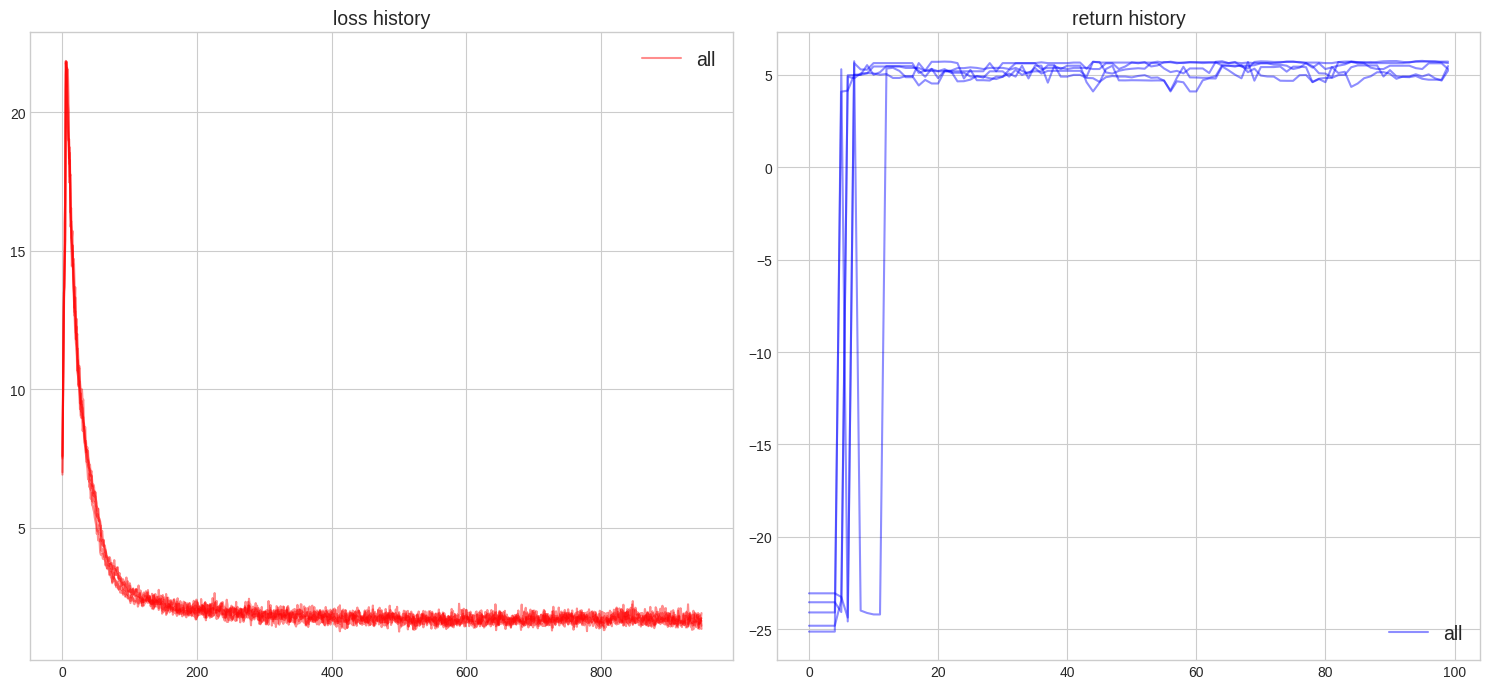

acquired action
action =  [10 10 10 10 10 10 10 10 10 10]
action =  [18 18 18 18 18 18 18 18 18 18]
action =  [19 19 19 19 19 19 19 19 19 19]
action =  [19 19 19 19 19 19 19 19 19 19]
action =  [17 17 17 17 17 17 17 17 17 17]
action =  [17 17 17 17 17 17 17 17 17 17]
action =  [17 17 17 17 17 17 17 17 17 17]
action =  [17 17 17 17 17 17 17 17 17 17]
action =  [17 17 17 17 17 17 17 17 17 17]
action =  [17 17 17 17 17 17 17 17 17 17]
return [5.642 5.642 5.642 5.642 5.642 5.642 5.642 5.642 5.642 5.642]
param distribution in model


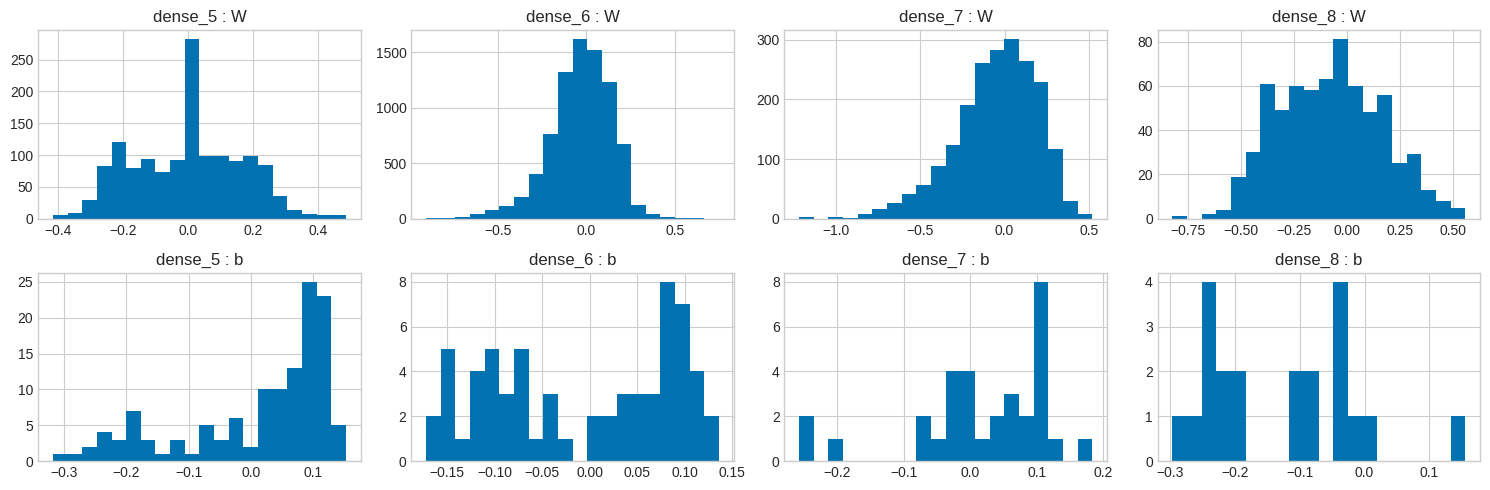

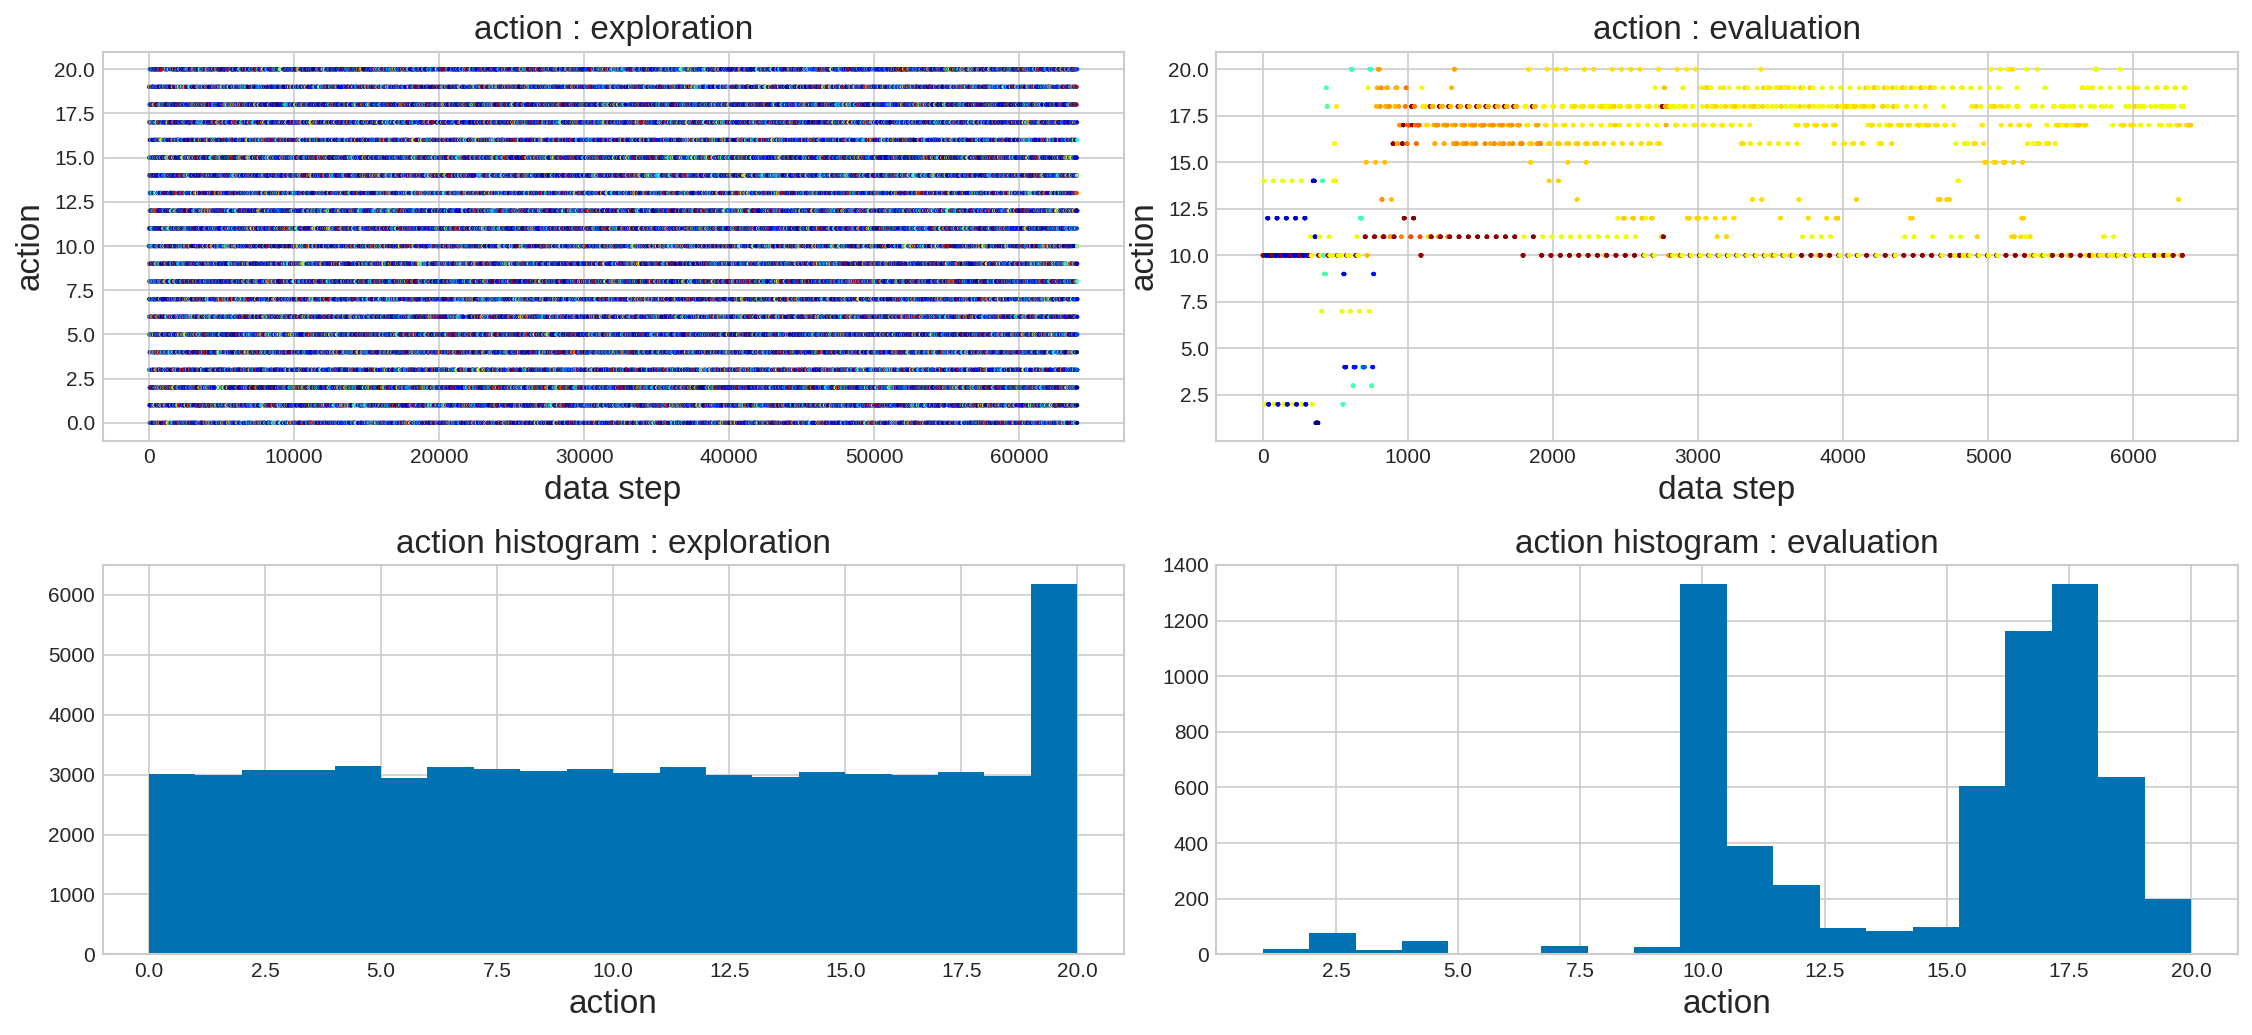

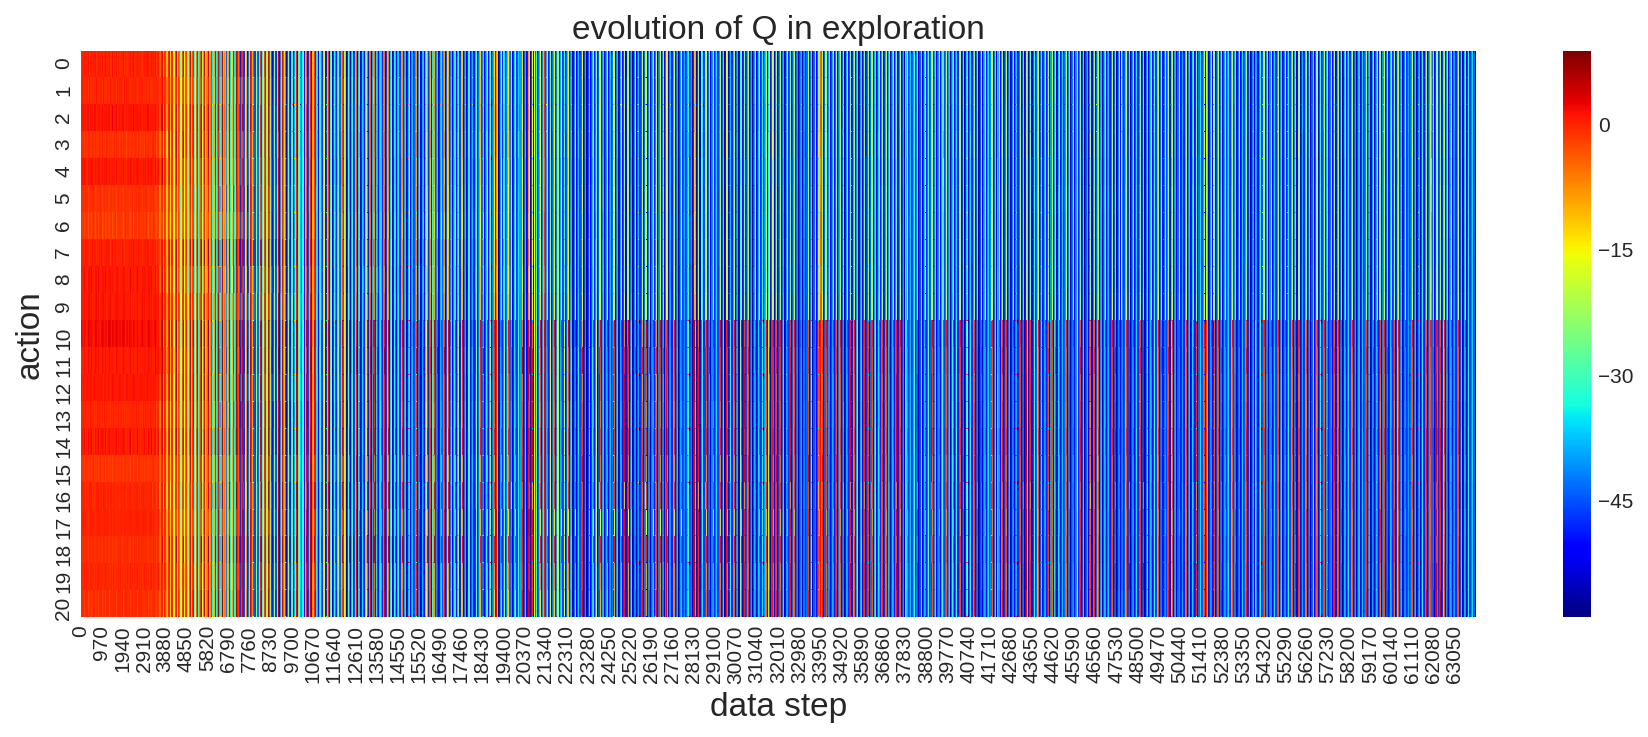

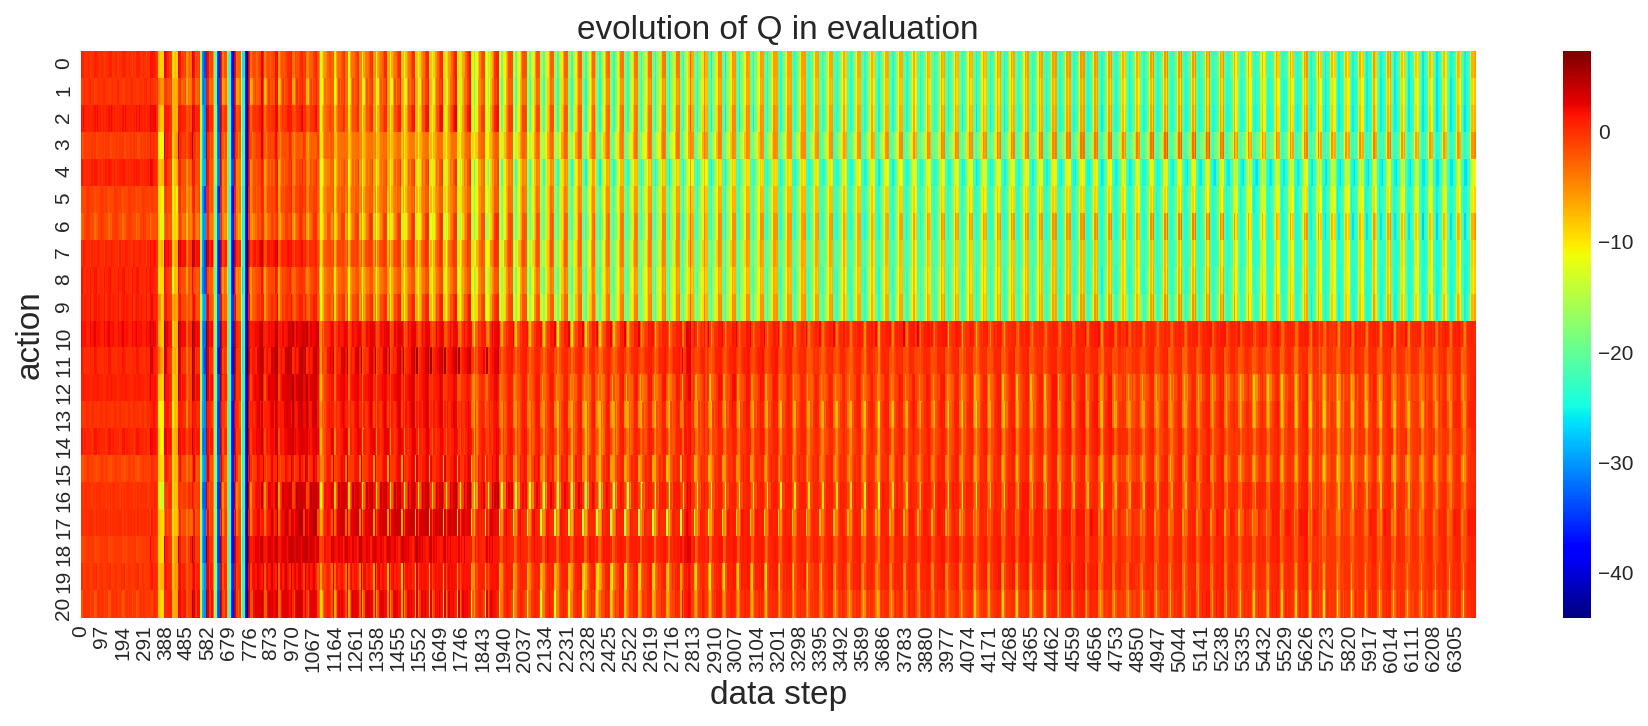

bankrupt=321659, total=352064, ratio=0.9136


In [6]:
import DQN_SER  # original DRL code
importlib.reload(DQN_SER)
from keras import optimizers

#df = pd.DataFrame()
for lr, eps, boltzmann, n_advantages, bankrupt_info in itertools.product([1e-3], [0.5], [False], [4], [True]):
    eps *= 10.0 if boltzmann else 1.0
    print('======================================================')
    print('lr={}, eps={}, boltzmann={}, n_advantages={}, bankrupt_info={}'
          .format(lr, eps, boltzmann, n_advantages, bankrupt_info))
    
    env = Env_Reserve.Environment(cashflow=cashflow, 
                                  interest=interest, hurdle=hurdle, 
                                  initial_cash=initial_cash, bankrupt_penalty=bankrupt_penalty, 
                                  bankrupt_info=True, 
                                  n_agents=64)

    model = DQN_SER.gen_model(input_shapes=env.shapes(), n_outputs=21, 
                              hidden_dims=[128, 64, 32], reg_l1=0.0, reg_l2=0.0, 
                              duel=False, duel_value_dim=16, duel_advantage_dim=64, 
                              output_reg=False, output_min=0, output_max=1)

    tester = DQN_SER.Tester(env, model)
    #n_trials = 5
    #n_steps = 10000
    tester.test(n_trials=n_trials, n_steps=n_steps,
                training_interval=10, n_batches=10, batch_size=256, 
                alpha=1.0, target_update_interval=20, 
                doubleQ=False,
                gamma=1.0/(1+hurdle), 
                optimizer=optimizers.Adam(lr, clipnorm=10.0, clipvalue=10.0),
                epsilon_start=10.0 if boltzmann else 1.0, epsilon_end=eps, epsilon_interval=n_steps, 
                boltzmann=boltzmann, 
                warmup_steps=500,
                verbose=False, verbose_interval=10, evaluate_interval=100,
                n_advantages=n_advantages, 
                category_weights={'bankrupt':0.5, 'ok':0.5}, default_weight=1.0, 
                get_log=True, 
                )
    
    viz = DQN_SER.Visualizer()
    viz.viz_action_history(tester.trainer, lambda x:x[0], 
                           cmap='jet', alpha=1.0, s=1.0)
    viz.viz_Q_history(tester.trainer)
    
    for trial in range(n_trials):
        df_temp = pd.DataFrame(np.ravel(tester.return_histories[trial]['all']), columns=['return'])
        df_temp['trial'] = trial
        df_temp['t'] = np.arange(len(df_temp))
        #df_temp['lr'] = lr
        #df_temp['eps'] = eps
        #df_temp['boltzmann'] = boltzmann
        #df_temp['n_advantages'] = n_advantages
        #df_temp['bankrupt_info'] = bankrupt_info
        df_temp['Agent'] = 'DQN_SER'

        df = pd.concat([df, df_temp])
        
    print('bankrupt={}, total={}, ratio={:.4f}'
      .format(env.done_bankrupt_counter, env.done_counter, env.done_bankrupt_counter/env.done_counter))
    env.done_counter = 0
    env.done_bankrupt_counter = 0
    
df.to_csv(tester.name + '.csv')

---
### DDPG

In [7]:
mu_min = 0.0
mu_max = 20.0

lr_p=0.0001, lr_v=0.001, boltzmann=False, sigma_end=1.0, tau_end=10
start testing... :  2019-11-08 00:32:49.515035
start 0/5 th trial...


100%|██████████| 10000/10000 [03:46<00:00, 44.10it/s]


start 1/5 th trial...


100%|██████████| 10000/10000 [03:56<00:00, 42.23it/s]


start 2/5 th trial...


100%|██████████| 10000/10000 [04:01<00:00, 41.45it/s]


start 3/5 th trial...


100%|██████████| 10000/10000 [04:10<00:00, 39.87it/s]


start 4/5 th trial...


100%|██████████| 10000/10000 [04:21<00:00, 38.22it/s]


end testing... :  2019-11-08 00:53:20.908668
loss and reward history


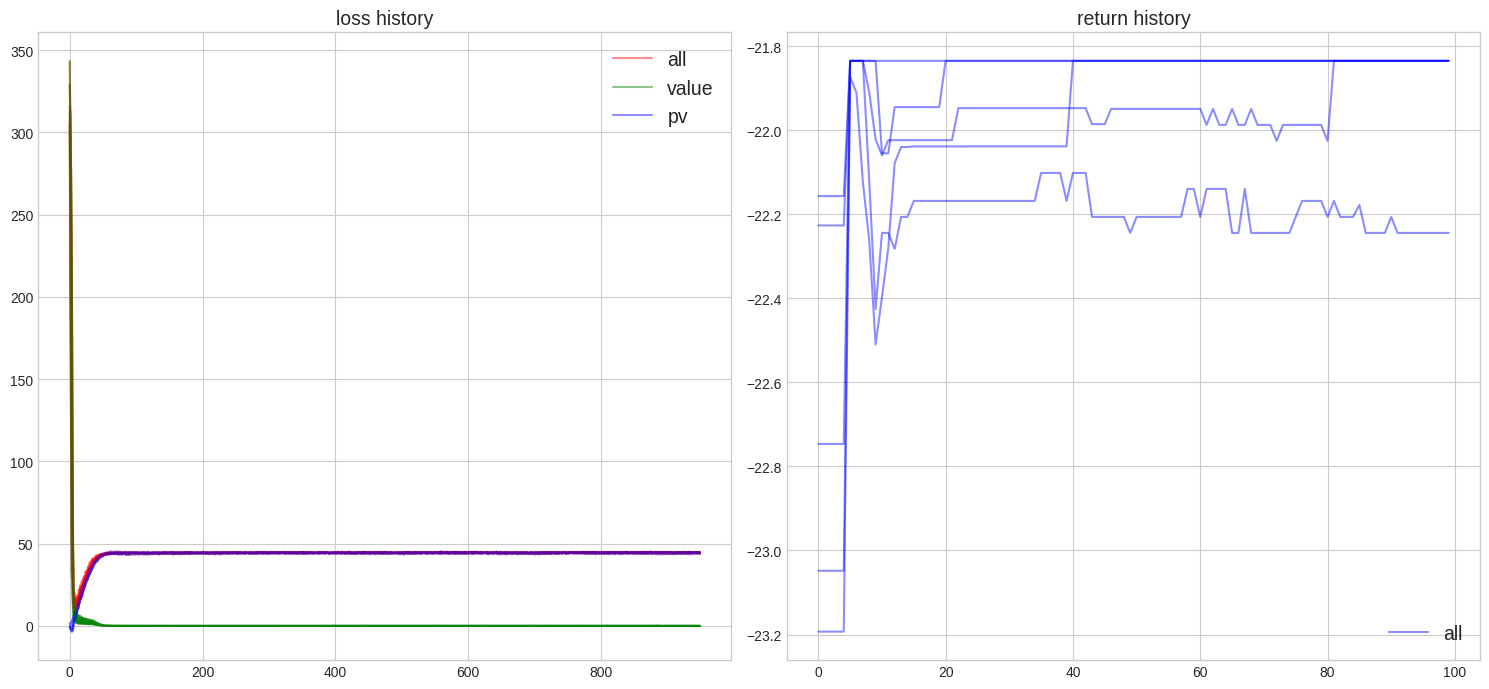

acquired action
action =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
action =  [11.734 11.734 11.734 11.734 11.734 11.734 11.734 11.734 11.734 11.734]
action =  [7.971 7.971 7.971 7.971 7.971 7.971 7.971 7.971 7.971 7.971]
action =  [6.557e-06 6.557e-06 6.557e-06 6.557e-06 6.557e-06 6.557e-06 6.557e-06
 6.557e-06 6.557e-06 6.557e-06]
action =  [12.677 12.677 12.677 12.677 12.677 12.677 12.677 12.677 12.677 12.677]
action =  [5.396 5.396 5.396 5.396 5.396 5.396 5.396 5.396 5.396 5.396]
action =  [13.409 13.409 13.409 13.409 13.409 13.409 13.409 13.409 13.409 13.409]
action =  [4.947e-05 4.947e-05 4.947e-05 4.947e-05 4.947e-05 4.947e-05 4.947e-05
 4.947e-05 4.947e-05 4.947e-05]
action =  [5.722e-05 5.722e-05 5.722e-05 5.722e-05 5.722e-05 5.722e-05 5.722e-05
 5.722e-05 5.722e-05 5.722e-05]
action =  [1.794 1.794 1.794 1.794 1.794 1.794 1.794 1.794 1.794 1.794]
return [-21.835 -21.835 -21.835 -21.835 -21.835 -21.835 -21.835 -21.835 -21.835
 -21.835]
param distribution in model_policy


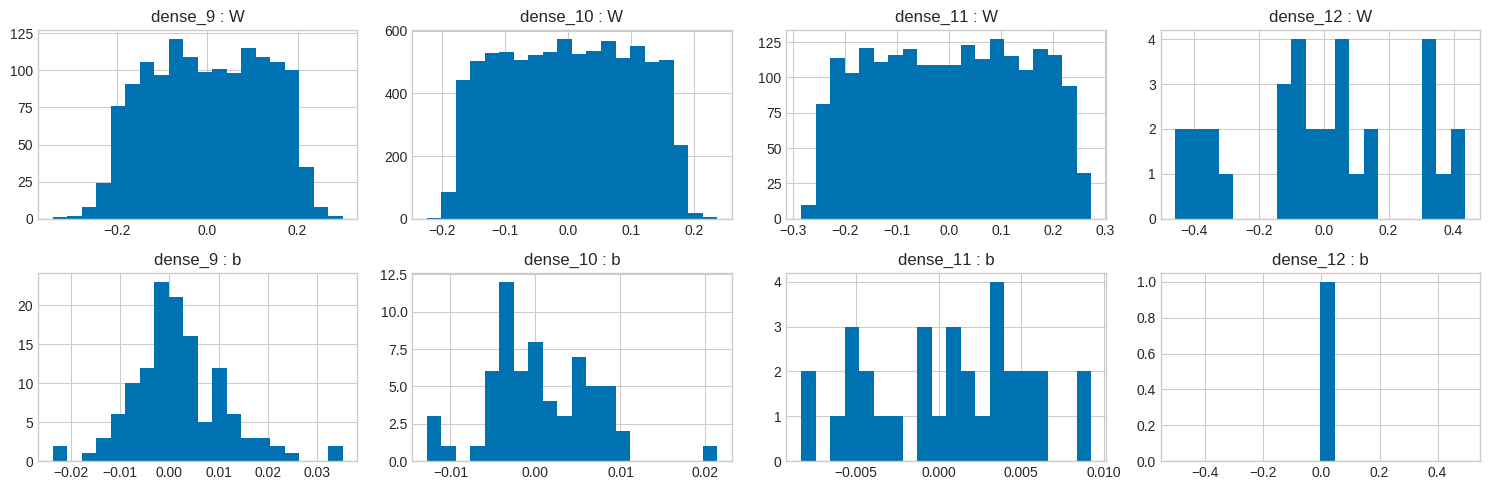

param distribution in model_value


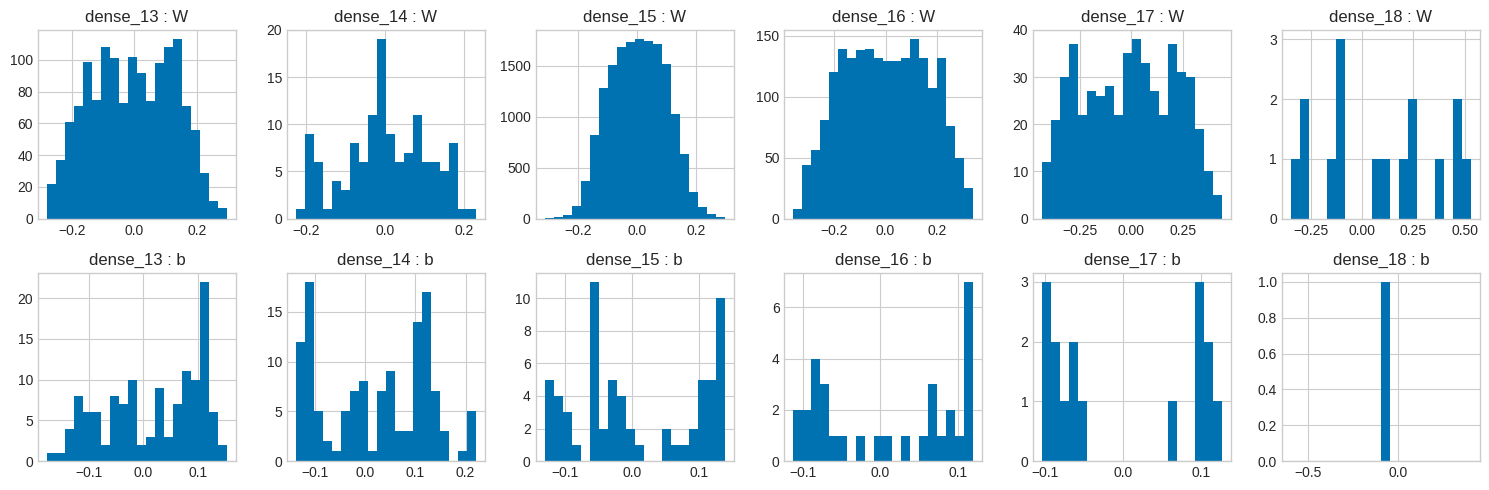

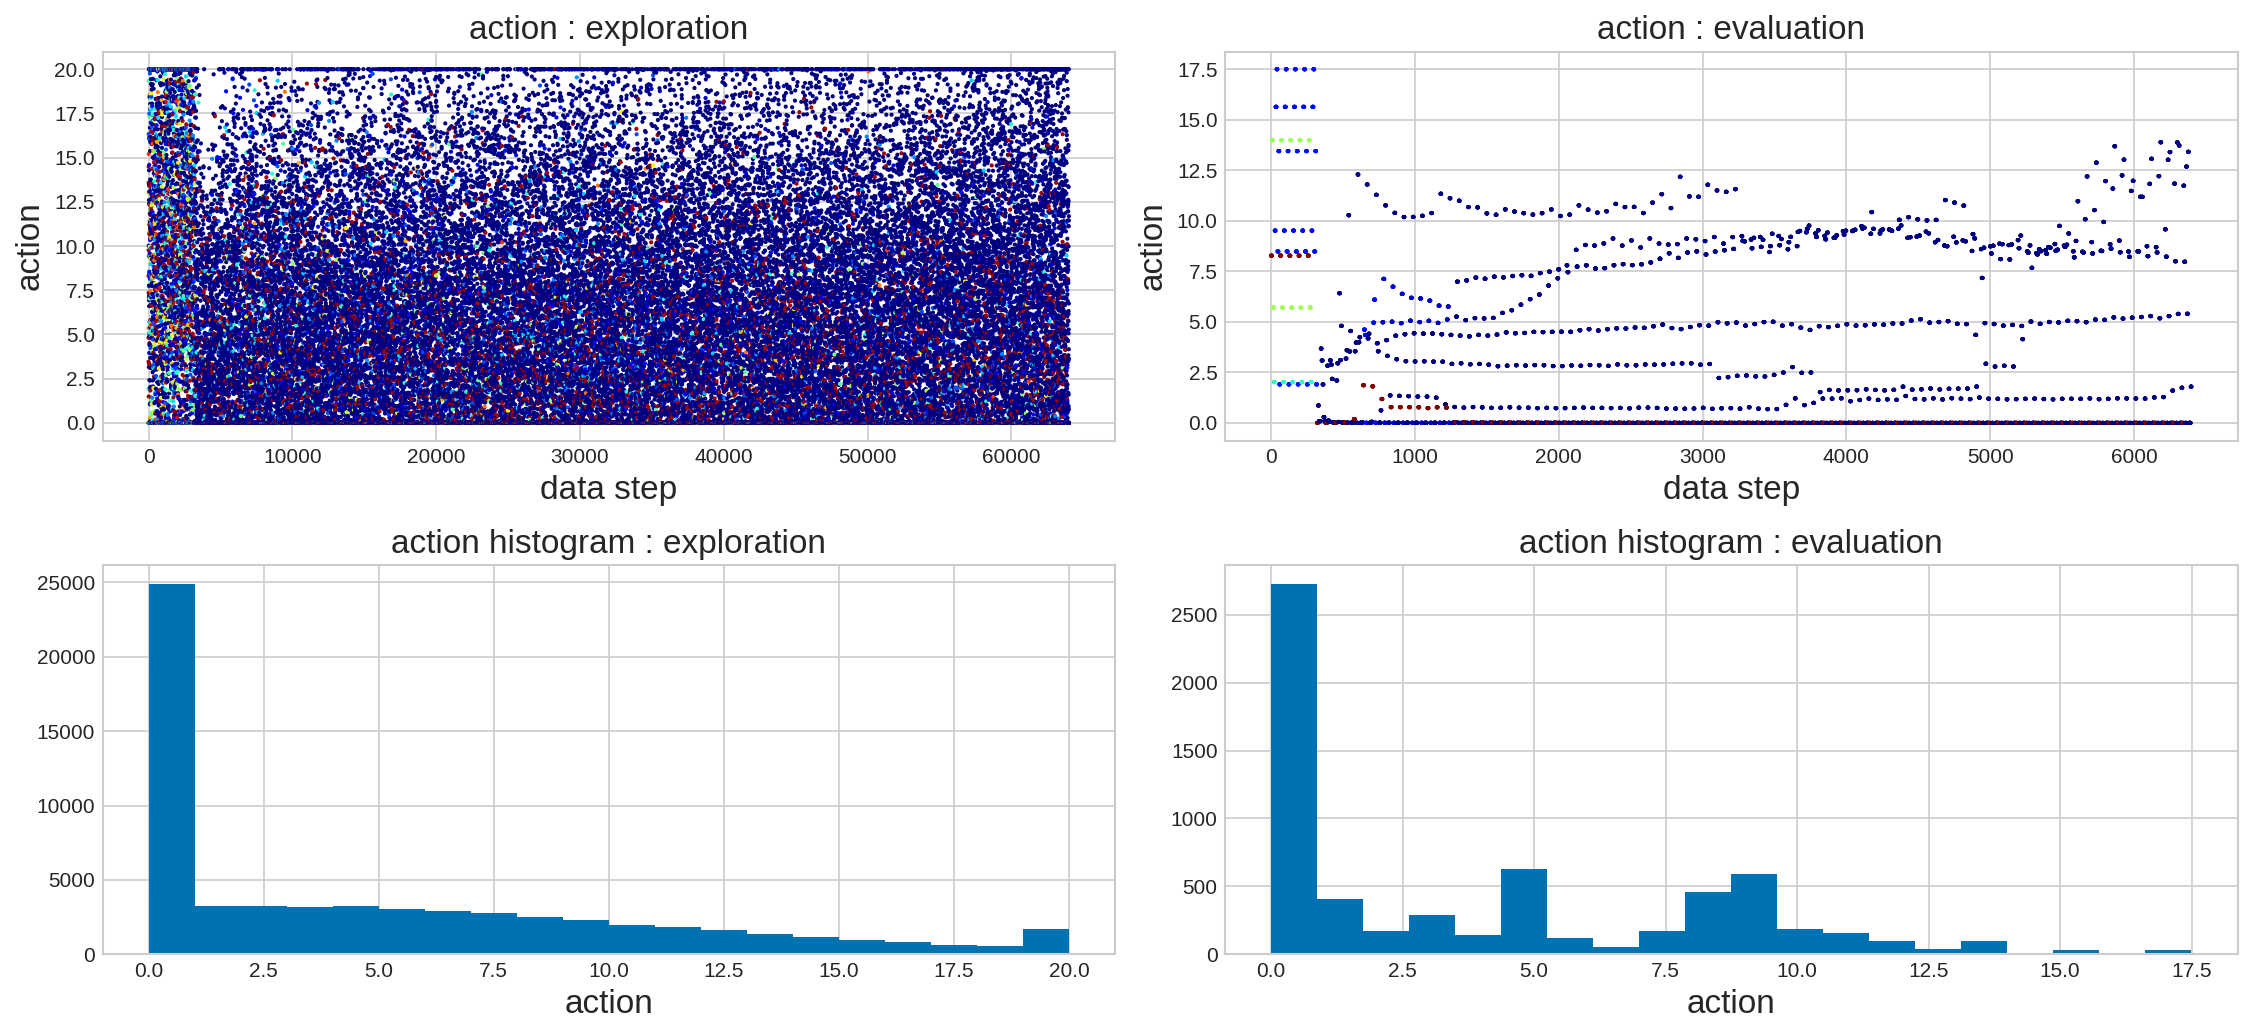

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


bankrupt=352054, total=352064, ratio=1.0000


In [8]:
import DDPG  # original DRL code
importlib.reload(DDPG)
from keras import optimizers

action_min = mu_min
action_max = mu_max
sigma_max = (action_max - action_min) / 3

model_policy = DDPG.gen_model_policy(state_shapes=env.shapes(), n_actions=1, 
                                     hidden_dims=[128, 64, 32], 
                                     reg_l1=0.0, reg_l2=0.0, 
                                     action_min=action_min, action_max=action_max, 
                                     batch_norm_input=False, 
                                     state_reg=False, state_min=0, state_max=10)

model_value = DDPG.gen_model_value(state_shapes=env.shapes(), n_actions=1, \
                                   hidden_action_dims=[128,], 
                                   hidden_state_dims=[128,],
                                   hidden_dims=[64, 32, 16],
                                   reg_l1=0.0, reg_l2=0.0,
                                   batch_norm_state_hidden=False)


#df = pd.DataFrame()
for lr_p, lr_v, boltzmann, sigma_end, tau_end in itertools.product(
    [1e-4,], [1e-3,], [False,], [1.0,], [10,]):
    print('======================================================')
    print('lr_p={}, lr_v={}, boltzmann={}, sigma_end={}, tau_end={}'
          .format(lr_p, lr_v, boltzmann, sigma_end, tau_end))
    
    tester = DDPG.Tester(env, model_policy, model_value, val_min=action_min, val_max=action_max)
    #n_trials = 5
    #n_steps = 10000
    tester.test(n_trials=n_trials,
                gamma=1.0/(1+hurdle),
                n_steps=n_steps, training_interval=10, n_batches=10, batch_size=256,
                target_update_interval_policy=20, target_update_interval_value=20,
                tau_policy=0.5, tau_value=0.5,
                optimizer_pv=optimizers.Adam(lr=lr_p), optimizer_value=optimizers.Adam(lr=lr_v),
                sigma_start=sigma_max, sigma_end=sigma_max*sigma_end, sigma_interval=n_steps,
                boltzmann=boltzmann, tau_start=10, tau_end=tau_end, tau_interval=n_steps, n_samples=64,
                verbose=False, verbose_interval=100, evaluate_interval=100, 
                wampup_steps=500, 
                get_log=True)

    viz = DDPG.Visualizer()
    viz.viz_action_history(tester.trainer, state_valuation=lambda x:x[0], action_valuation=lambda x:x, 
                               cmap='jet', alpha=1.0, s=1.0)
    viz.viz_Q_history(trainer=tester.trainer, 
                      state_valuation=lambda x:np.ravel(x[0][:, 0]), 
                      action_valuation=lambda x:np.ravel(x[:, 0]),
                      data_span_exp=100, data_span_eva=100,)
    
    for trial in range(n_trials):
        df_temp = pd.DataFrame(np.ravel(tester.return_histories[trial]['all']), columns=['return'])
        df_temp['trial'] = trial
        df_temp['t'] = np.arange(len(df_temp))
        #df_temp['lr_p'] = lr_p
        #df_temp['lr_v'] = lr_v
        #df_temp['boltzmann'] = boltzmann
        #df_temp['sigma_end'] = sigma_end
        #df_temp['tau_end'] = tau_end
        df_temp['Agent'] = 'DDPG'

        df = pd.concat([df, df_temp])

    #ModelInspection.inspect_hidden_layers(tester.env, tester.model, tester.agent, show_hidden_hist=True)
    print('bankrupt={}, total={}, ratio={:.4f}'
      .format(env.done_bankrupt_counter, env.done_counter, env.done_bankrupt_counter/env.done_counter))
    env.done_counter = 0
    env.done_bankrupt_counter = 0

df.to_csv(tester.name + '.csv')

lr_p=0.0001, lr_v=0.001, boltzmann=False, sigma_end=1.0, tau_end=10
start testing... :  2019-11-08 00:53:38.146863
start 0/5 th trial...


100%|██████████| 10000/10000 [04:52<00:00, 34.19it/s]


start 1/5 th trial...


100%|██████████| 10000/10000 [04:58<00:00, 22.80it/s]


start 2/5 th trial...


100%|██████████| 10000/10000 [05:06<00:00, 32.58it/s]


start 3/5 th trial...


100%|██████████| 10000/10000 [05:08<00:00, 24.27it/s]


start 4/5 th trial...


100%|██████████| 10000/10000 [05:18<00:00, 22.36it/s]


end testing... :  2019-11-08 01:19:25.644390
loss and reward history


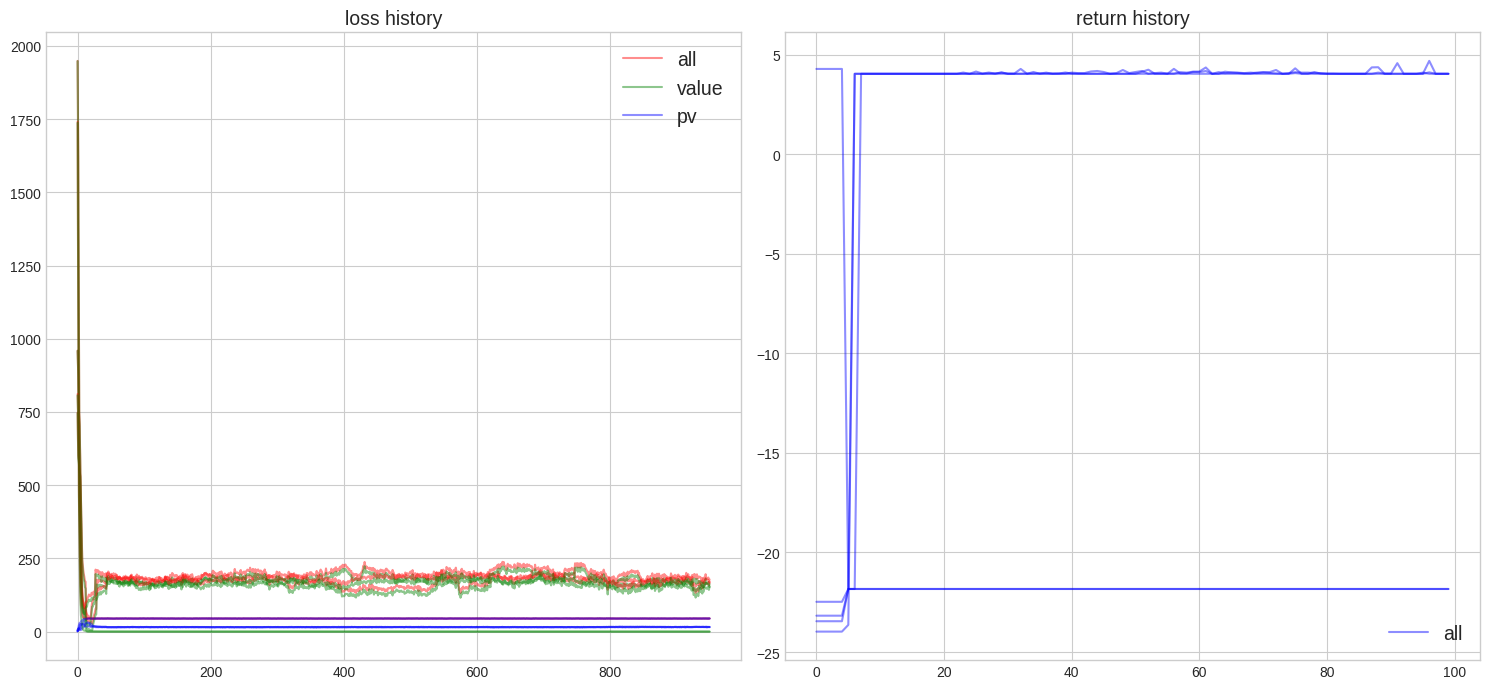

acquired action
action =  [19.868 19.868 19.868 19.868 19.868 19.868 19.868 19.868 19.868 19.868]
action =  [19.909 19.909 19.909 19.909 19.909 19.909 19.909 19.909 19.909 19.909]
action =  [19.989 19.989 19.989 19.989 19.989 19.989 19.989 19.989 19.989 19.989]
action =  [19.992 19.992 19.992 19.992 19.992 19.992 19.992 19.992 19.992 19.992]
action =  [19.994 19.994 19.994 19.994 19.994 19.994 19.994 19.994 19.994 19.994]
action =  [19.995 19.995 19.995 19.995 19.995 19.995 19.995 19.995 19.995 19.995]
action =  [19.998 19.998 19.998 19.998 19.998 19.998 19.998 19.998 19.998 19.998]
action =  [19.992 19.992 19.992 19.992 19.992 19.992 19.992 19.992 19.992 19.992]
action =  [19.957 19.957 19.957 19.957 19.957 19.957 19.957 19.957 19.957 19.957]
action =  [19.459 19.459 19.459 19.459 19.459 19.459 19.459 19.459 19.459 19.459]
return [4.033 4.033 4.033 4.033 4.033 4.033 4.033 4.033 4.033 4.033]
param distribution in model_policy


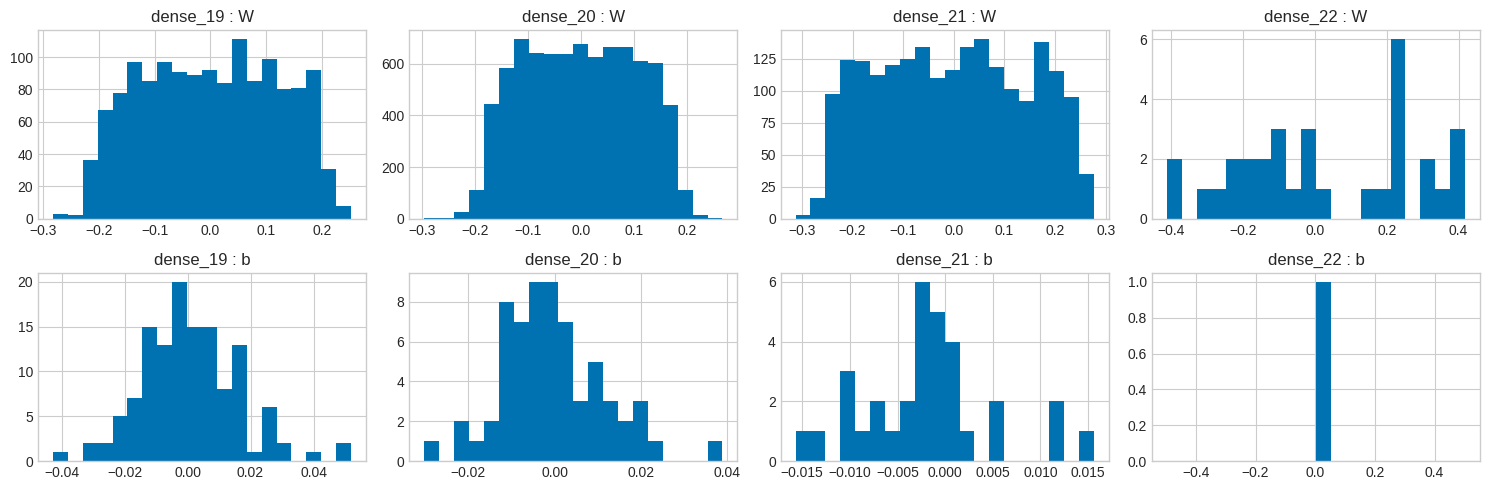

param distribution in model_value


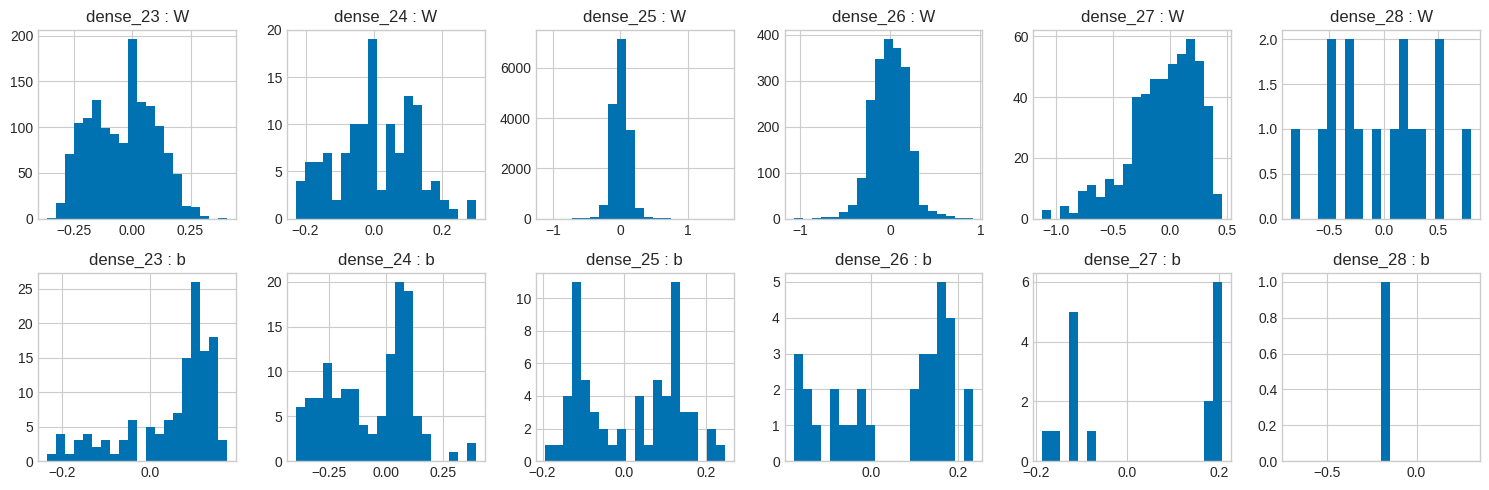

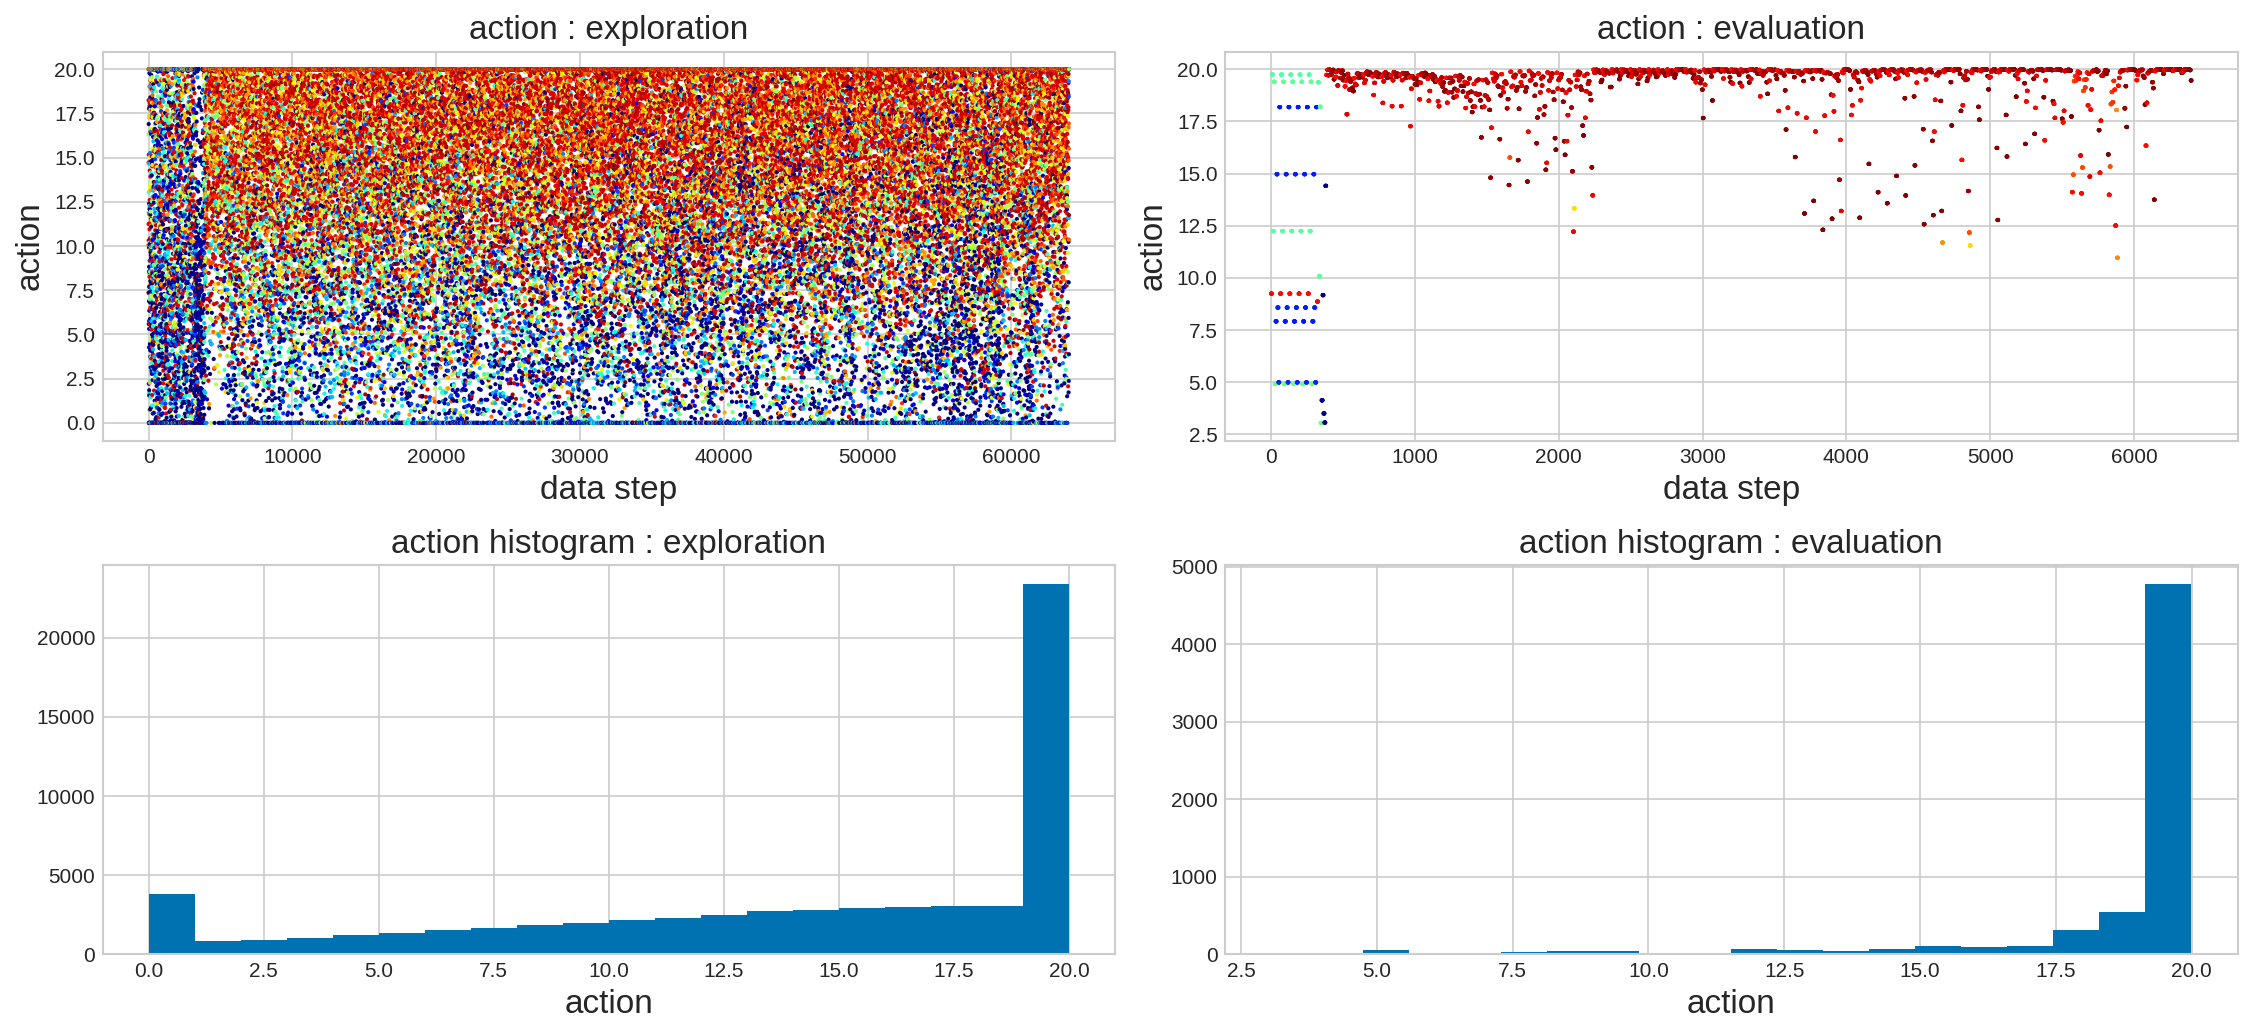

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


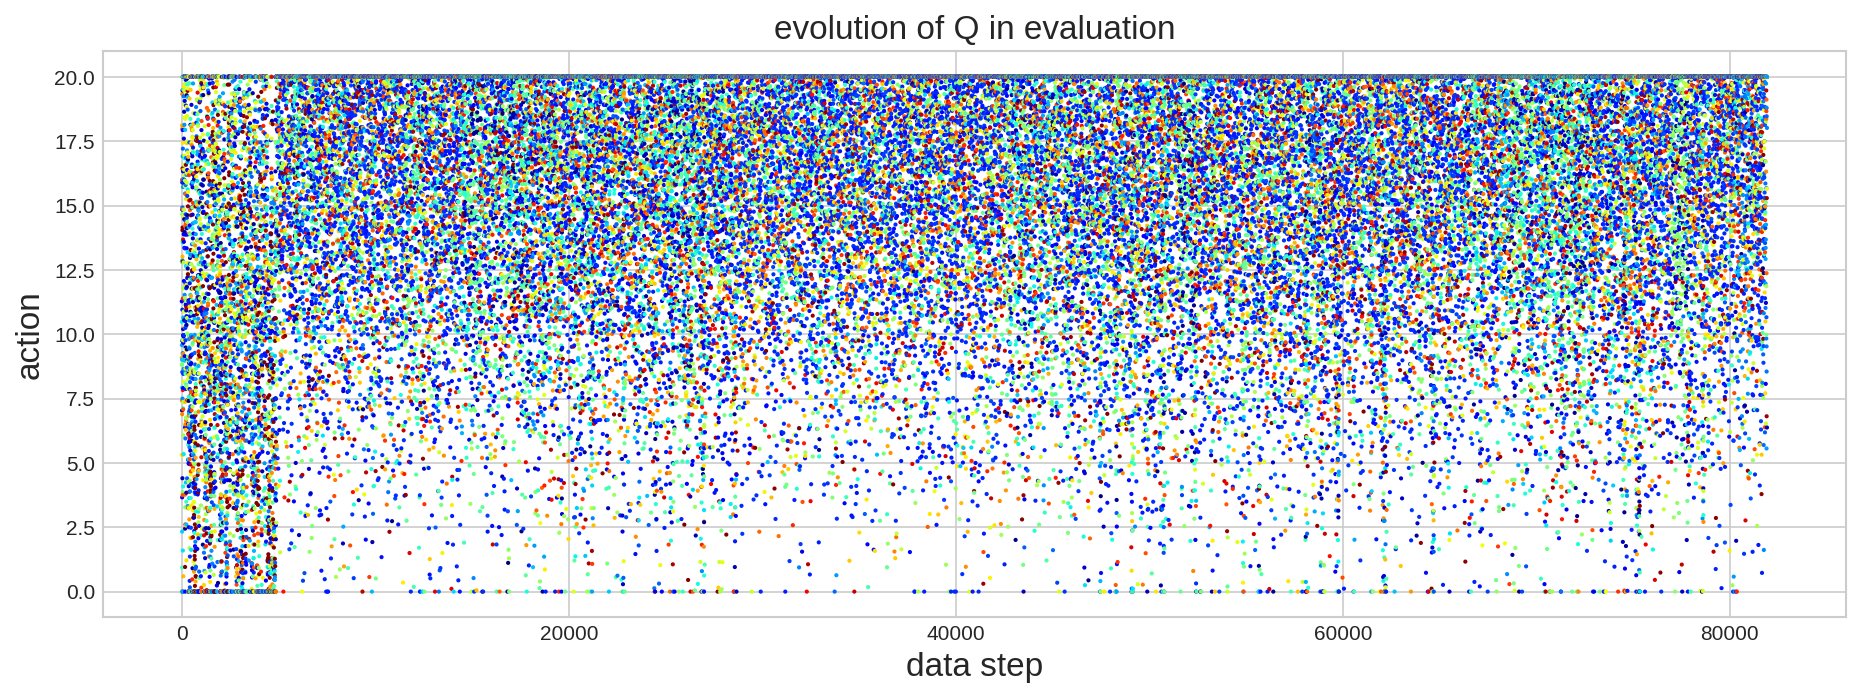

bankrupt=269600, total=352064, ratio=0.7658


In [9]:
import DDPG_SER  # original DRL code
importlib.reload(DDPG_SER)
from keras import optimizers

action_min = mu_min
action_max = mu_max
sigma_max = (action_max - action_min) / 3

model_policy = DDPG_SER.gen_model_policy(state_shapes=env.shapes(), n_actions=1, 
                                     hidden_dims=[128, 64, 32], 
                                     reg_l1=0.0, reg_l2=0.0, 
                                     action_min=action_min, action_max=action_max, 
                                     batch_norm_input=False, 
                                     state_reg=False, state_min=0, state_max=10)

model_value = DDPG_SER.gen_model_value(state_shapes=env.shapes(), n_actions=1, \
                                   hidden_action_dims=[128,], 
                                   hidden_state_dims=[128,],
                                   hidden_dims=[64, 32, 16],
                                   reg_l1=0.0, reg_l2=0.0,
                                   batch_norm_state_hidden=False)


#df = pd.DataFrame()
for lr_p, lr_v, boltzmann, sigma_end, tau_end in itertools.product(
    [1e-4,], [1e-3,], [False,], [1.0,], [10,]):
    print('======================================================')
    print('lr_p={}, lr_v={}, boltzmann={}, sigma_end={}, tau_end={}'
          .format(lr_p, lr_v, boltzmann, sigma_end, tau_end))
    
    tester = DDPG_SER.Tester(env, model_policy, model_value, val_min=action_min, val_max=action_max)
    #n_trials = 5
    #n_steps = 10000
    tester.test(n_trials=n_trials,
                n_steps=n_steps, training_interval=10, n_batches=10, batch_size=256,
                target_update_interval_policy=20, target_update_interval_value=20,
                tau_policy=0.5, tau_value=0.5,
                buf_alpha=0.5, buf_beta=0.5, buf_mode='rank',
                gamma=1.0/(1+hurdle),
                optimizer_pv=optimizers.Adam(lr=lr_p), optimizer_value=optimizers.Adam(lr=lr_v),
                sigma_start=sigma_max, sigma_end=sigma_max*sigma_end, sigma_interval=n_steps,
                boltzmann=boltzmann, tau_start=10, tau_end=tau_end, tau_interval=n_steps, n_samples=64,
                policy_sampling_update=False, policy_sampling_n=64,
                policy_sampling_sigma_start=10.0, policy_sampling_sigma_end=1.0, policy_sampling_sigma_interval=n_steps,
                warmpup_steps=500,
                n_advantages=10, 
                category_weights={'bankrupt':0.5, 'ok':0.5}, default_weight=1.0, 
                verbose=False, verbose_interval=10, evaluate_interval=100,
                get_log=True, save_objects=False)

    viz = DDPG_SER.Visualizer()
    viz.viz_action_history(tester.trainer, state_valuation=lambda x:x[0], action_valuation=lambda x:x, 
                               cmap='jet', alpha=1.0, s=1.0)
    viz.viz_Q_history(trainer=tester.trainer, 
                      state_valuation=lambda x:np.ravel(x[0][:, 0]), 
                      action_valuation=lambda x:np.ravel(x[:, 0]),
                      data_span_exp=100, data_span_eva=100,)
    
    for trial in range(n_trials):
        df_temp = pd.DataFrame(np.ravel(tester.return_histories[trial]['all']), columns=['return'])
        df_temp['trial'] = trial
        df_temp['t'] = np.arange(len(df_temp))
        #df_temp['lr_p'] = lr_p
        #df_temp['lr_v'] = lr_v
        #df_temp['boltzmann'] = boltzmann
        #df_temp['sigma_end'] = sigma_end
        #df_temp['tau_end'] = tau_end
        df_temp['Agent'] = 'DDPG_SER'

        df = pd.concat([df, df_temp])

    print('bankrupt={}, total={}, ratio={:.4f}'
      .format(env.done_bankrupt_counter, env.done_counter, env.done_bankrupt_counter/env.done_counter))
    env.done_counter = 0
    env.done_bankrupt_counter = 0
    #ModelInspection.inspect_hidden_layers(tester.env, tester.model, tester.agent, show_hidden_hist=True)

df.to_csv(tester.name + '.csv')

---
### AWR

lr=1e-05, mult_critic=1.0, mult_entropy=0.1
start testing... :  2019-11-08 01:19:41.706030
start 0/5 th trial...


  5%|▍         | 468/10000 [00:02<14:44, 10.78it/s]  W1108 01:19:46.741032 140141868304192 deprecation.py:323] From /home/deepstation/.pyenv/versions/anaconda3-5.0.1/envs/ForChainer/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
100%|██████████| 10000/10000 [01:28<00:00, 112.85it/s]


start 1/5 th trial...


100%|██████████| 10000/10000 [01:31<00:00, 108.88it/s]


start 2/5 th trial...


100%|██████████| 10000/10000 [01:33<00:00, 109.64it/s]


start 3/5 th trial...


100%|██████████| 10000/10000 [01:33<00:00, 107.25it/s]


start 4/5 th trial...


100%|██████████| 10000/10000 [01:42<00:00, 97.10it/s]


end testing... :  2019-11-08 01:27:41.605874
loss and reward history


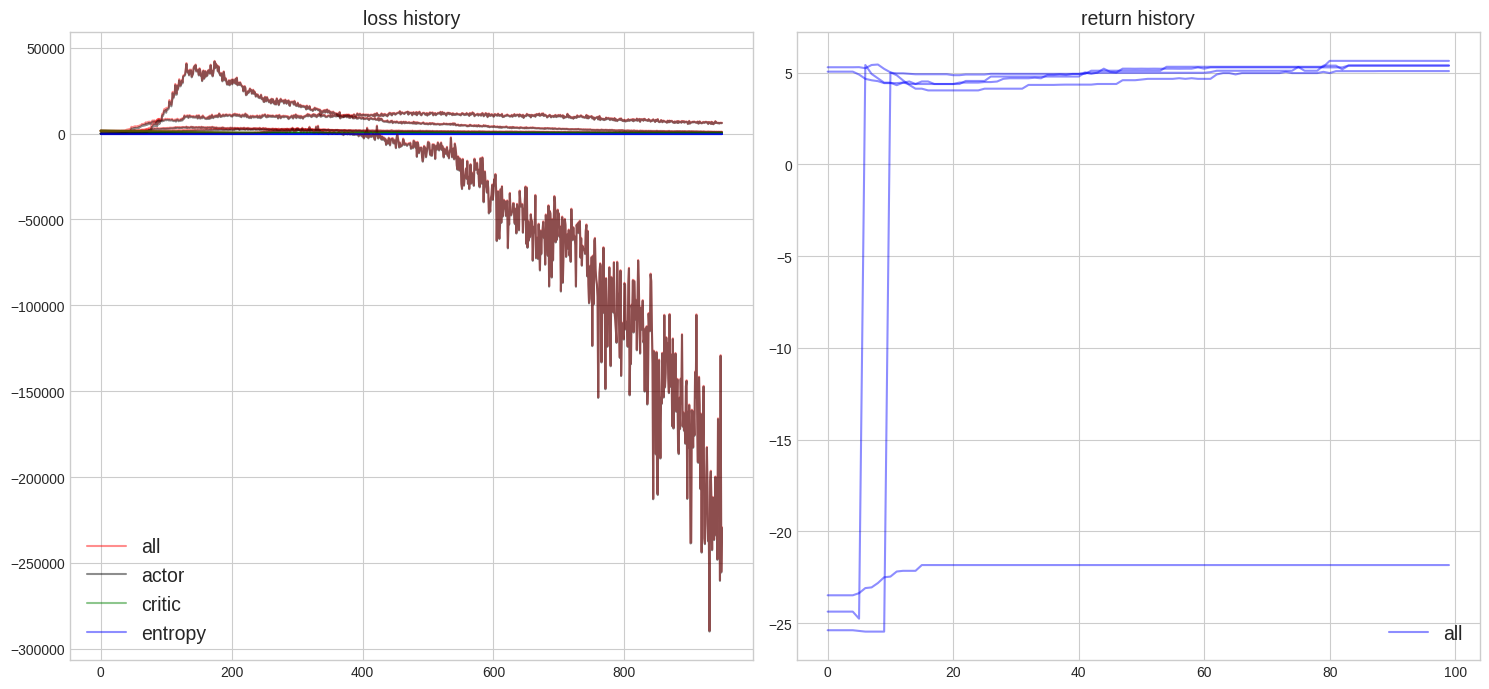

acquired action
action =  [0.008 0.008 0.008 0.008 0.008 0.008 0.008 0.008 0.008 0.008]
action =  [0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004]
action =  [0.051 0.051 0.051 0.051 0.051 0.051 0.051 0.051 0.051 0.051]
action =  [0.153 0.153 0.153 0.153 0.153 0.153 0.153 0.153 0.153 0.153]
action =  [0.074 0.074 0.074 0.074 0.074 0.074 0.074 0.074 0.074 0.074]
action =  [0.076 0.076 0.076 0.076 0.076 0.076 0.076 0.076 0.076 0.076]
action =  [0.097 0.097 0.097 0.097 0.097 0.097 0.097 0.097 0.097 0.097]
action =  [0.085 0.085 0.085 0.085 0.085 0.085 0.085 0.085 0.085 0.085]
action =  [0.141 0.141 0.141 0.141 0.141 0.141 0.141 0.141 0.141 0.141]
action =  [0.821 0.821 0.821 0.821 0.821 0.821 0.821 0.821 0.821 0.821]
return [-21.835 -21.835 -21.835 -21.835 -21.835 -21.835 -21.835 -21.835 -21.835
 -21.835]
param distribution in model


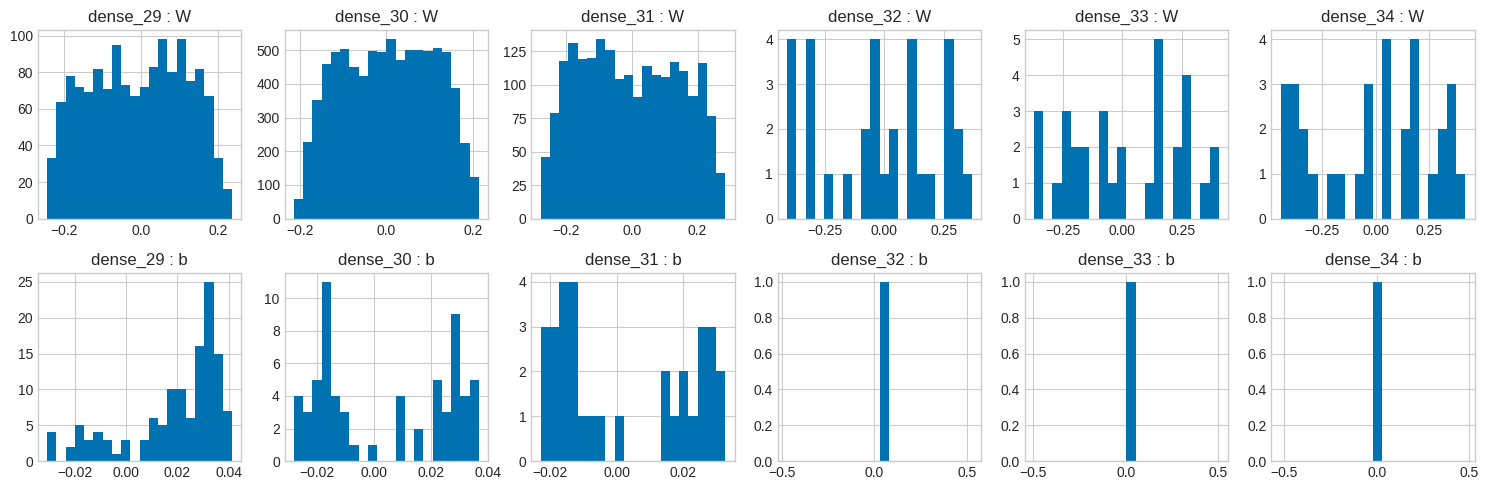

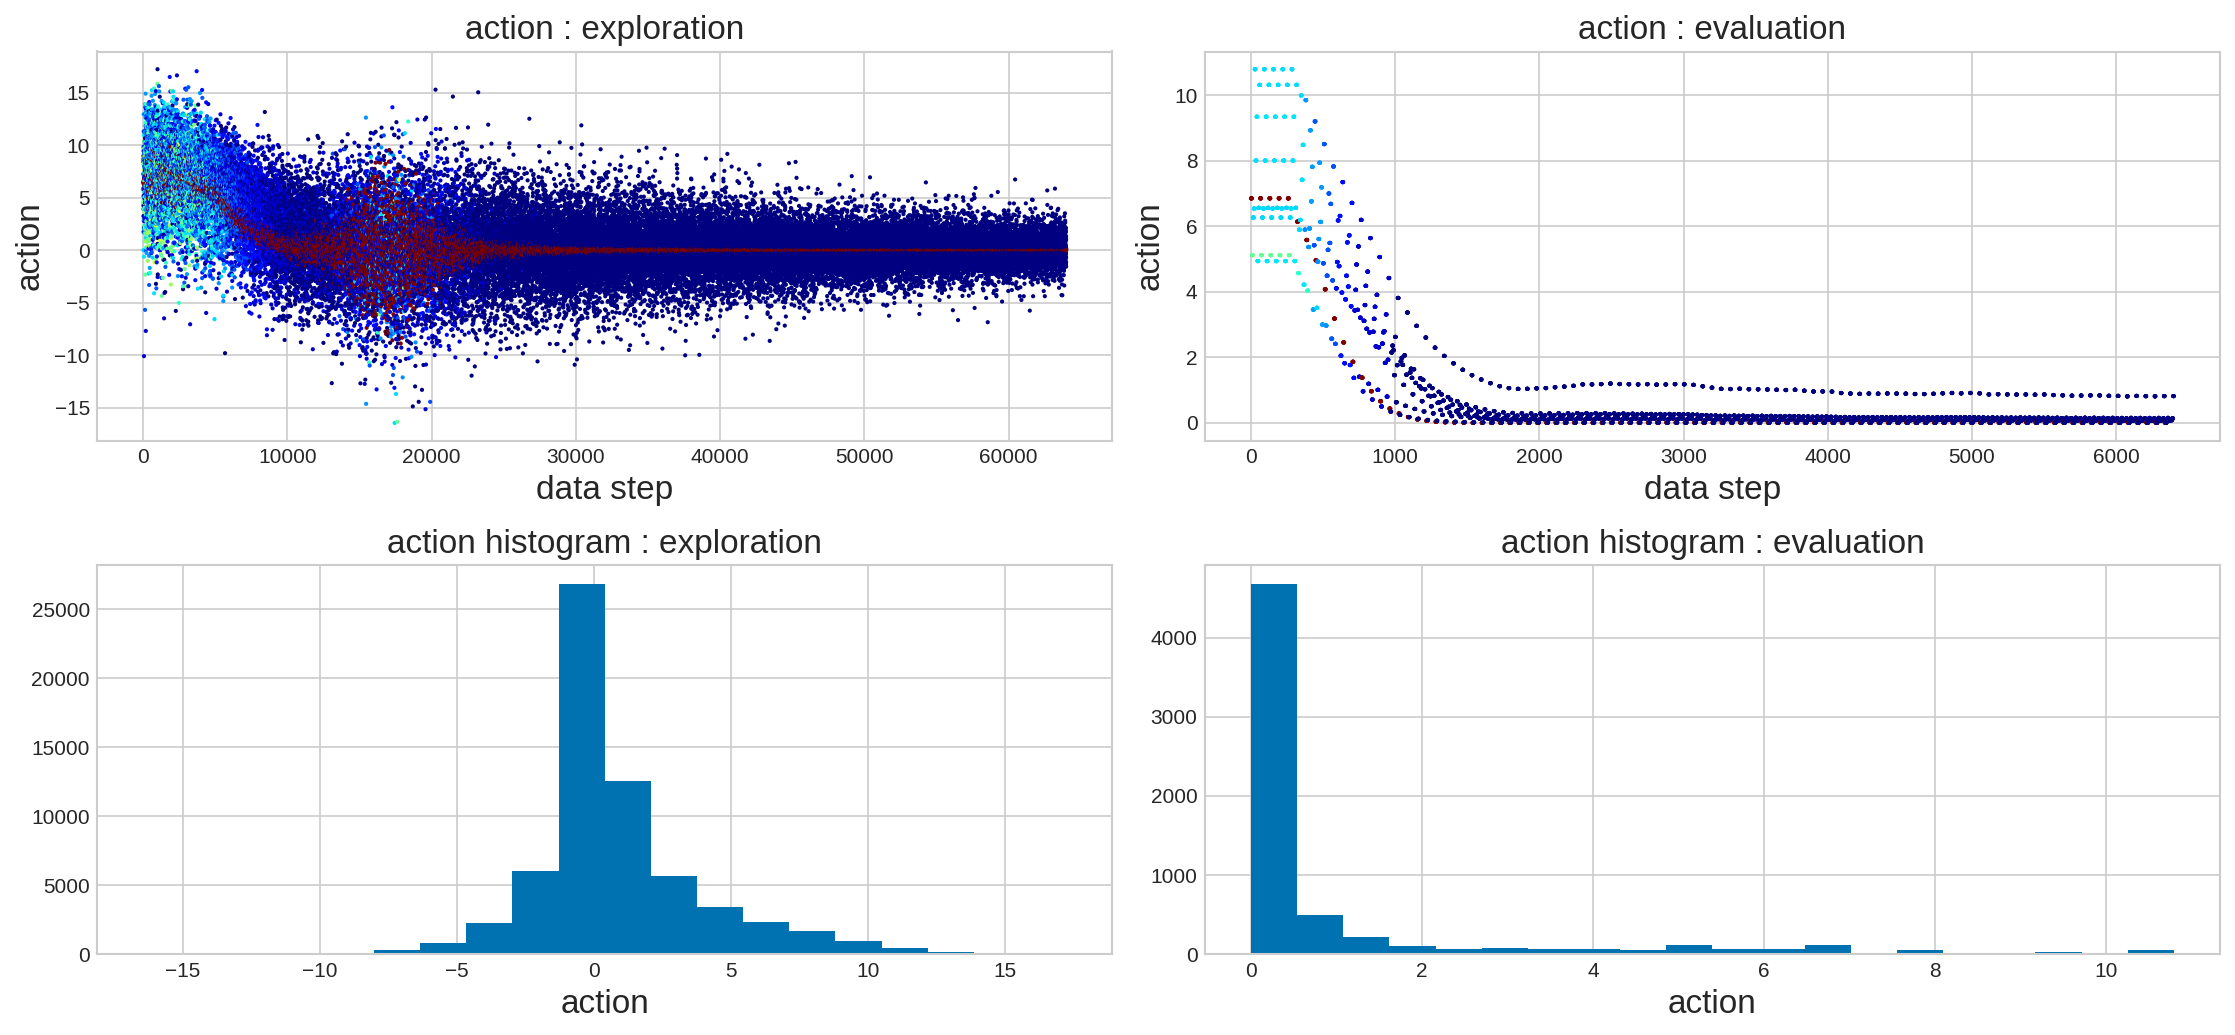

bankrupt=246621, total=453387, ratio=0.5440


In [10]:
import AWR
importlib.reload(AWR)  # original DRL code

from keras import optimizers

env = Env_Reserve.Environment(cashflow=cashflow, 
                              interest=interest, hurdle=hurdle, 
                              initial_cash=initial_cash, bankrupt_penalty=bankrupt_penalty, 
                              bankrupt_info=False, 
                              n_agents=64)

mu_min = mu_min
mu_max = mu_max
sigma_max = (mu_max - mu_min) / 3

model = AWR.gen_model(input_shapes=env.shapes(), n_outputs=1, \
                      hidden_dims=[128, 64, 32], reg_l1=1e-6, reg_l2=1e-6, \
                      state_reg=False, state_min=-1.0, state_max=1.0,
                      action_reg=True, 
                      action_min=mu_min, action_max=mu_max, 
                      action_sigma_min=0.0001, action_sigma_max=sigma_max, 
                      value_reg=False, value_min=0, value_max=1)

#df = pd.DataFrame()
for lr, mult_critic, mult_entropy in itertools.product(
    [1e-5,], [1.0,], [1e-1,]):
    print('======================================================')
    print('lr={}, mult_critic={}, mult_entropy={}'
          .format(lr, mult_critic, mult_entropy))
    
    tester = AWR.Tester(env, model, 
                        action_min=mu_min-3*sigma_max, 
                        action_max=mu_max+3*sigma_max)
    #n_trials = 1
    #n_steps = 10000
    tester.test(n_trials=n_trials, n_steps=n_steps, 
                training_interval=10, n_batches=10, batch_size=256,
                buf_alpha=0.5, buf_beta=0.5, buf_mode='rank',
                gamma=1.0/(1+hurdle), 
                optimizer=optimizers.Adam(lr=lr, clipnorm=10.0, clipvalue=10.0),
                mult_actor=1.0, mult_critic=mult_critic, mult_entropy=mult_entropy, mult_beta=1.0, 
                verbose=False, verbose_interval=100, evaluate_interval=100, 
                get_log=True)

    viz = AWR.Visualizer()
    viz.viz_action_history(tester.trainer, state_valuation=lambda x:x[0], action_valuation=lambda x:x, 
                           cmap='jet', alpha=1.0, s=1.0)

    for trial in range(n_trials):
        df_temp = pd.DataFrame(np.ravel(tester.return_histories[trial]['all']), columns=['return'])
        df_temp['trial'] = trial
        df_temp['t'] = np.arange(len(df_temp))
        #df_temp['lr'] = lr
        #df_temp['mult_critic'] = mult_critic
        #df_temp['mult_entropy'] = mult_entropy
        df_temp['Agent'] = 'AWR'

        df = pd.concat([df, df_temp])

    #ModelInspection.inspect_hidden_layers(tester.env, tester.model, tester.agent, show_hidden_hist=True)
    print('bankrupt={}, total={}, ratio={:.4f}'
      .format(env.done_bankrupt_counter, env.done_counter, env.done_bankrupt_counter/env.done_counter))
    env.done_counter = 0
    env.done_bankrupt_counter = 0

df.to_csv(tester.name + '.csv')

lr=1e-05, mult_critic=1.0, mult_entropy=0.1
start testing... :  2019-11-08 01:27:46.220435
start 0/5 th trial...


100%|██████████| 10000/10000 [01:42<00:00, 97.76it/s]


start 1/5 th trial...


100%|██████████| 10000/10000 [01:38<00:00, 99.17it/s]


start 2/5 th trial...


100%|██████████| 10000/10000 [01:47<00:00, 83.34it/s]


start 3/5 th trial...


100%|██████████| 10000/10000 [01:50<00:00, 87.86it/s]


start 4/5 th trial...


100%|██████████| 10000/10000 [01:48<00:00, 92.31it/s]


end testing... :  2019-11-08 01:36:47.355700
loss and reward history


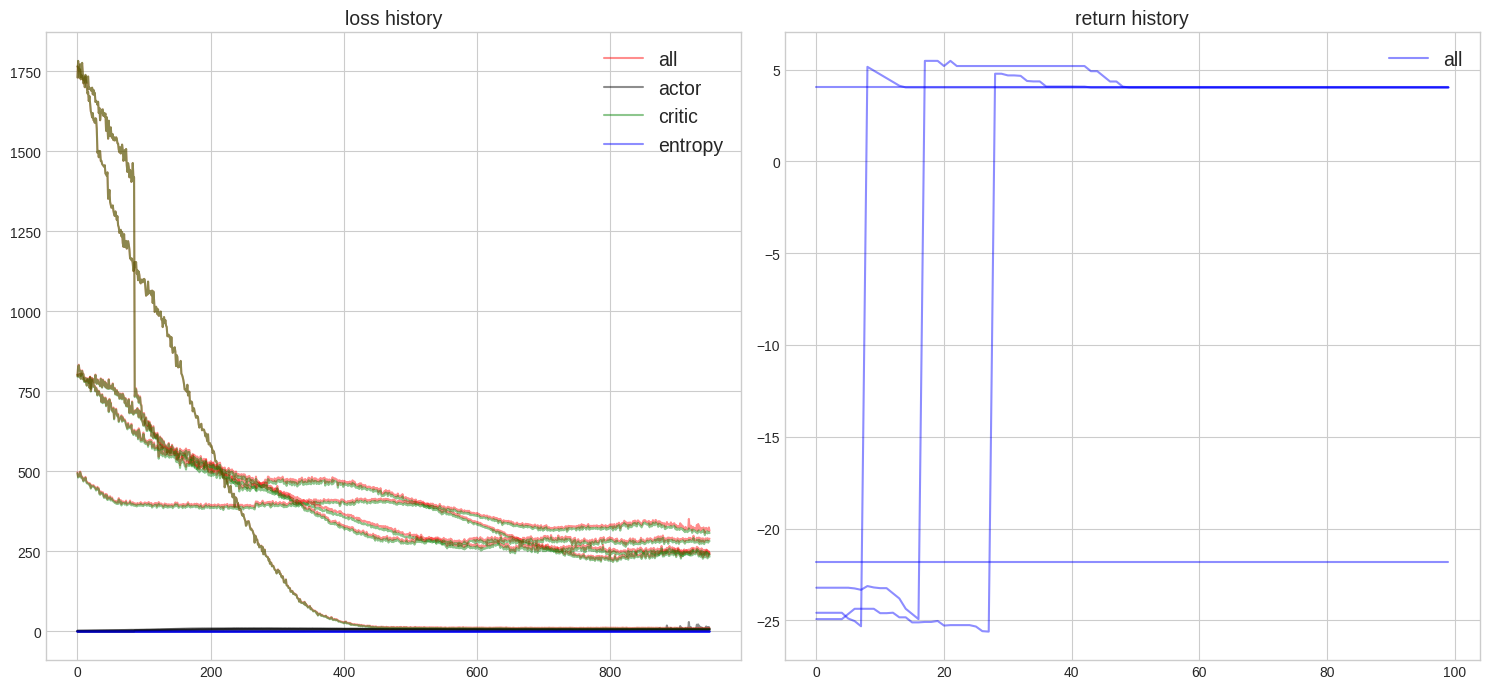

acquired action
action =  [19.905 19.905 19.905 19.905 19.905 19.905 19.905 19.905 19.905 19.905]
action =  [19.524 19.524 19.524 19.524 19.524 19.524 19.524 19.524 19.524 19.524]
action =  [19.981 19.981 19.981 19.981 19.981 19.981 19.981 19.981 19.981 19.981]
action =  [19.858 19.858 19.858 19.858 19.858 19.858 19.858 19.858 19.858 19.858]
action =  [19.875 19.875 19.875 19.875 19.875 19.875 19.875 19.875 19.875 19.875]
action =  [19.562 19.562 19.562 19.562 19.562 19.562 19.562 19.562 19.562 19.562]
action =  [19.978 19.978 19.978 19.978 19.978 19.978 19.978 19.978 19.978 19.978]
action =  [19.976 19.976 19.976 19.976 19.976 19.976 19.976 19.976 19.976 19.976]
action =  [19.847 19.847 19.847 19.847 19.847 19.847 19.847 19.847 19.847 19.847]
action =  [19.699 19.699 19.699 19.699 19.699 19.699 19.699 19.699 19.699 19.699]
return [4.033 4.033 4.033 4.033 4.033 4.033 4.033 4.033 4.033 4.033]
param distribution in model


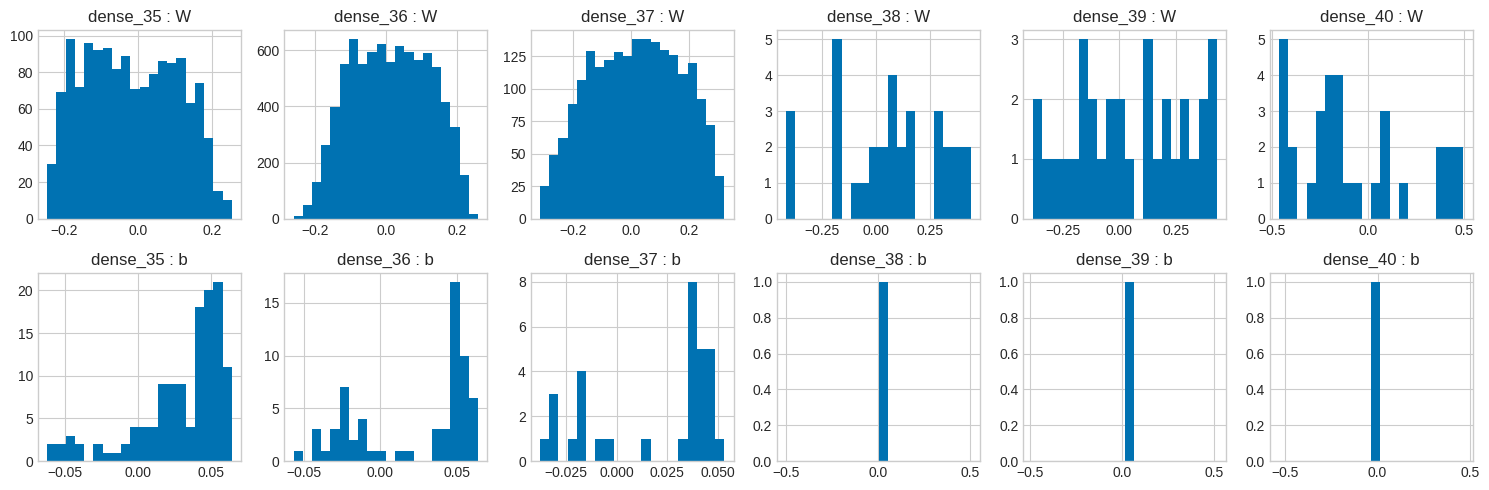

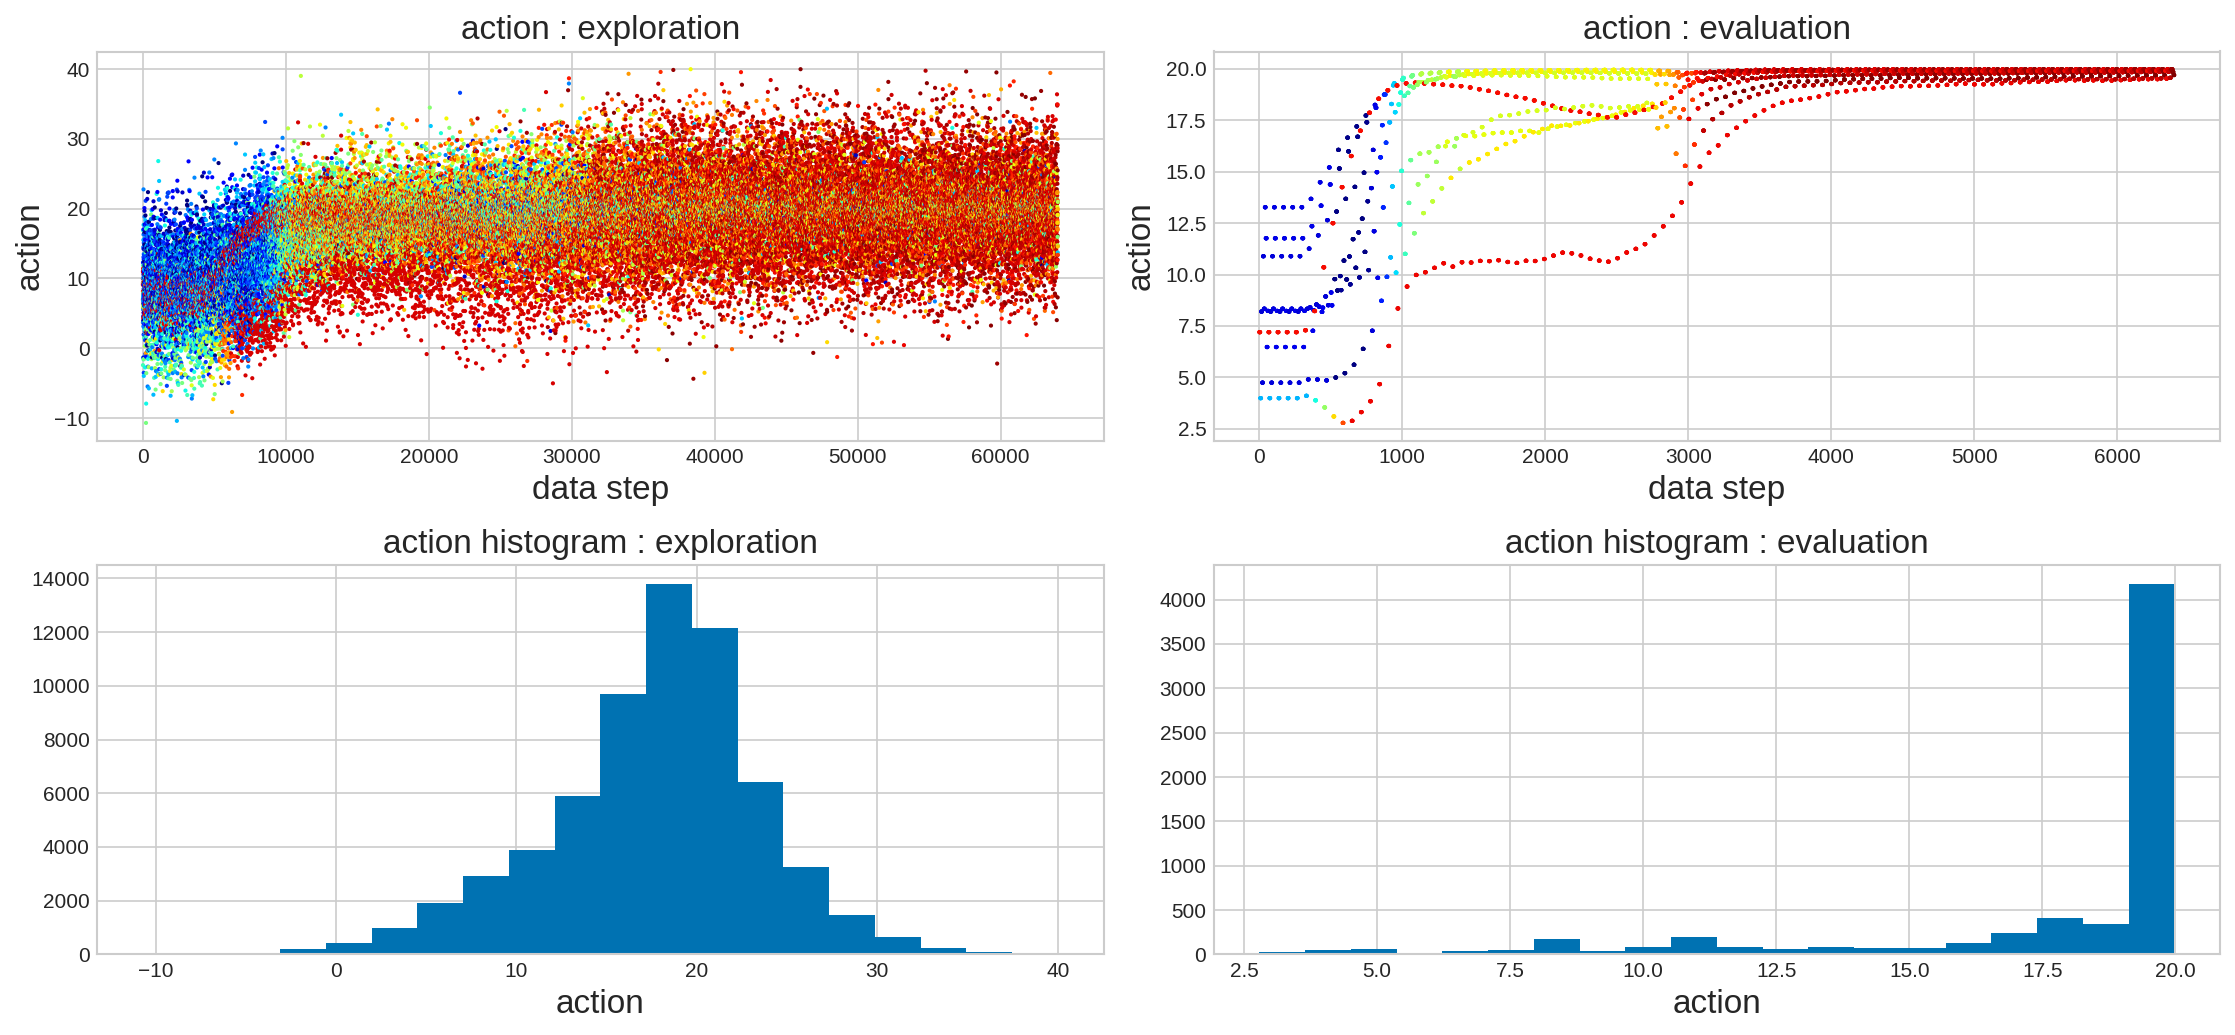

bankrupt=329887, total=526554, ratio=0.6265


In [11]:
import AWR
importlib.reload(AWR)  # original DRL code

from keras import optimizers

env = Env_Reserve.Environment(cashflow=cashflow, 
                              interest=interest, hurdle=hurdle, 
                              initial_cash=initial_cash, bankrupt_penalty=bankrupt_penalty, 
                              bankrupt_info=True, 
                              n_agents=64)

mu_min = mu_min
mu_max = mu_max
sigma_max = (mu_max - mu_min) / 3

model = AWR.gen_model(input_shapes=env.shapes(), n_outputs=1, \
                      hidden_dims=[128, 64, 32], reg_l1=1e-6, reg_l2=1e-6, \
                      state_reg=False, state_min=-1.0, state_max=1.0,
                      action_reg=True, 
                      action_min=mu_min, action_max=mu_max, 
                      action_sigma_min=0.0001, action_sigma_max=sigma_max, 
                      value_reg=False, value_min=0, value_max=1)

#df = pd.DataFrame()
for lr, mult_critic, mult_entropy in itertools.product(
    [1e-5,], [1.0,], [1e-1,]):
    print('======================================================')
    print('lr={}, mult_critic={}, mult_entropy={}'
          .format(lr, mult_critic, mult_entropy))
    
    tester = AWR.Tester(env, model, 
                        action_min=mu_min-3*sigma_max, 
                        action_max=mu_max+3*sigma_max)
    #n_trials = 1
    #n_steps = 10000
    tester.test(n_trials=n_trials, n_steps=n_steps, 
                training_interval=10, n_batches=10, batch_size=256,
                buf_alpha=0.5, buf_beta=0.5, buf_mode='rank',
                gamma=1.0/(1+hurdle), 
                optimizer=optimizers.Adam(lr=lr, clipnorm=10.0, clipvalue=10.0),
                mult_actor=1.0, mult_critic=mult_critic, mult_entropy=mult_entropy, mult_beta=10.0, 
                category_weights={'bankrupt':0.5, 'ok':0.5}, default_weight=1.0, 
                verbose=False, verbose_interval=100, evaluate_interval=100, 
                get_log=True)

    viz = AWR.Visualizer()
    viz.viz_action_history(tester.trainer, state_valuation=lambda x:x[0], action_valuation=lambda x:x, 
                           cmap='jet', alpha=1.0, s=1.0)

    for trial in range(n_trials):
        df_temp = pd.DataFrame(np.ravel(tester.return_histories[trial]['all']), columns=['return'])
        df_temp['trial'] = trial
        df_temp['t'] = np.arange(len(df_temp))
        #df_temp['lr'] = lr
        #df_temp['mult_critic'] = mult_critic
        #df_temp['mult_entropy'] = mult_entropy
        df_temp['Agent'] = 'AWR_SER'

        df = pd.concat([df, df_temp])

    #ModelInspection.inspect_hidden_layers(tester.env, tester.model, tester.agent, show_hidden_hist=True)
    print('bankrupt={}, total={}, ratio={:.4f}'
      .format(env.done_bankrupt_counter, env.done_counter, env.done_bankrupt_counter/env.done_counter))
    env.done_counter = 0
    env.done_bankrupt_counter = 0

df.to_csv(tester.name + '.csv')

---
## 3. Results

In [12]:
pd.options.display.precision = 4
ids = ['Agent',]
df[df['t'].max()*0.9<=df['t']].groupby(ids)['return'].describe()

count     mean      std      min      25%      50%      75%      max
Agent                                                                         
AWR        50.0  -0.0668  10.9960 -21.8348   5.0860   5.3837   5.3890   5.6423
AWR_SER    50.0  -1.1406  10.4522 -21.8348   4.0330   4.0330   4.0330   4.0330
DDPG       50.0 -21.9159   0.1640 -22.2443 -21.8348 -21.8348 -21.8348 -21.8348
DDPG_SER   50.0  -6.2876  12.8236 -21.8348 -21.8348   4.0330   4.0330   4.6821
DQN        50.0 -13.9500  12.1706 -21.8348 -21.8348 -21.8348   4.0430   5.2526
DQN_SER    50.0   5.3579   0.3779   4.6966   4.9307   5.5005   5.7048   5.7627

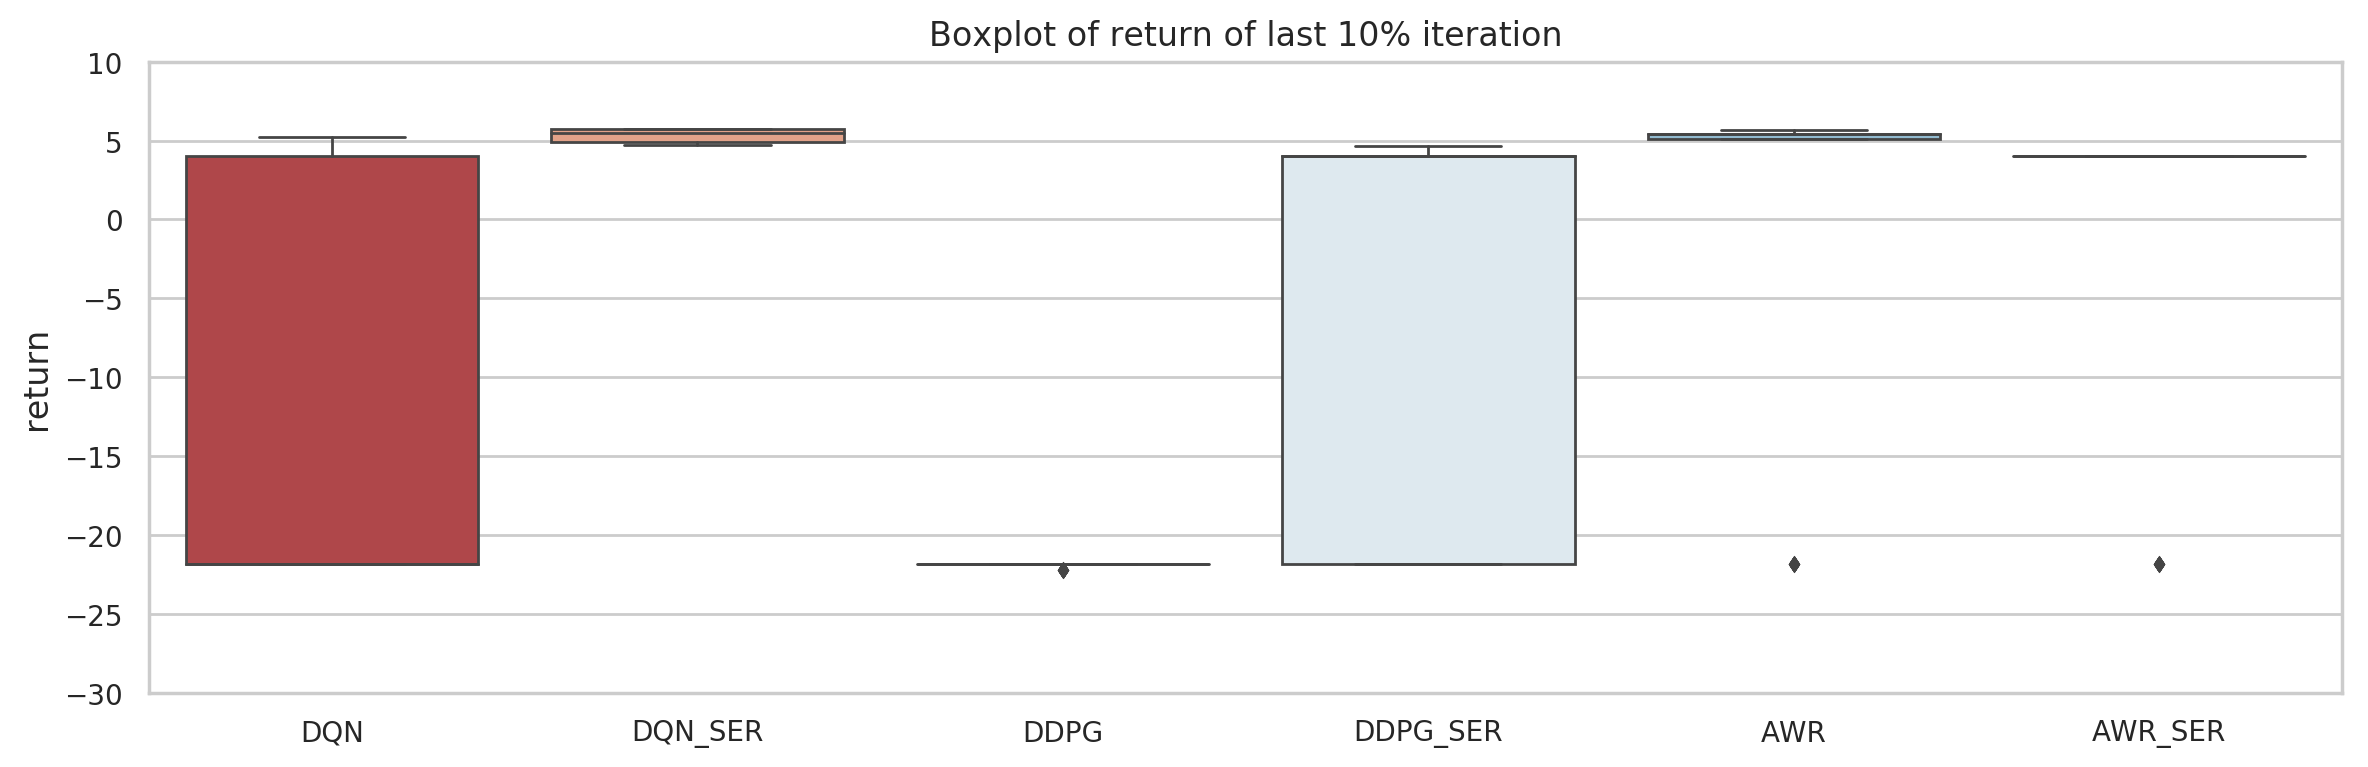

In [13]:
sns.set_style("whitegrid")
sns.set_context("notebook")

plt.figure(figsize=(12, 4), dpi=200)

sns.boxplot(data=df[df['t'].max()*0.9<=df['t']], x='Agent', y='return', orient='v', fliersize=3.0, linewidth=1.0, palette='RdBu')

plt.title('Boxplot of return of last 10% iteration', fontsize=12)
plt.ylim(-30, 10)
plt.xlabel('', fontsize=12)
plt.ylabel('return', fontsize=12)
plt.tick_params(labelsize=10)

plt.tight_layout()
plt.show()

/home/deepstation/.pyenv/versions/anaconda3-5.0.1/envs/ForChainer/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


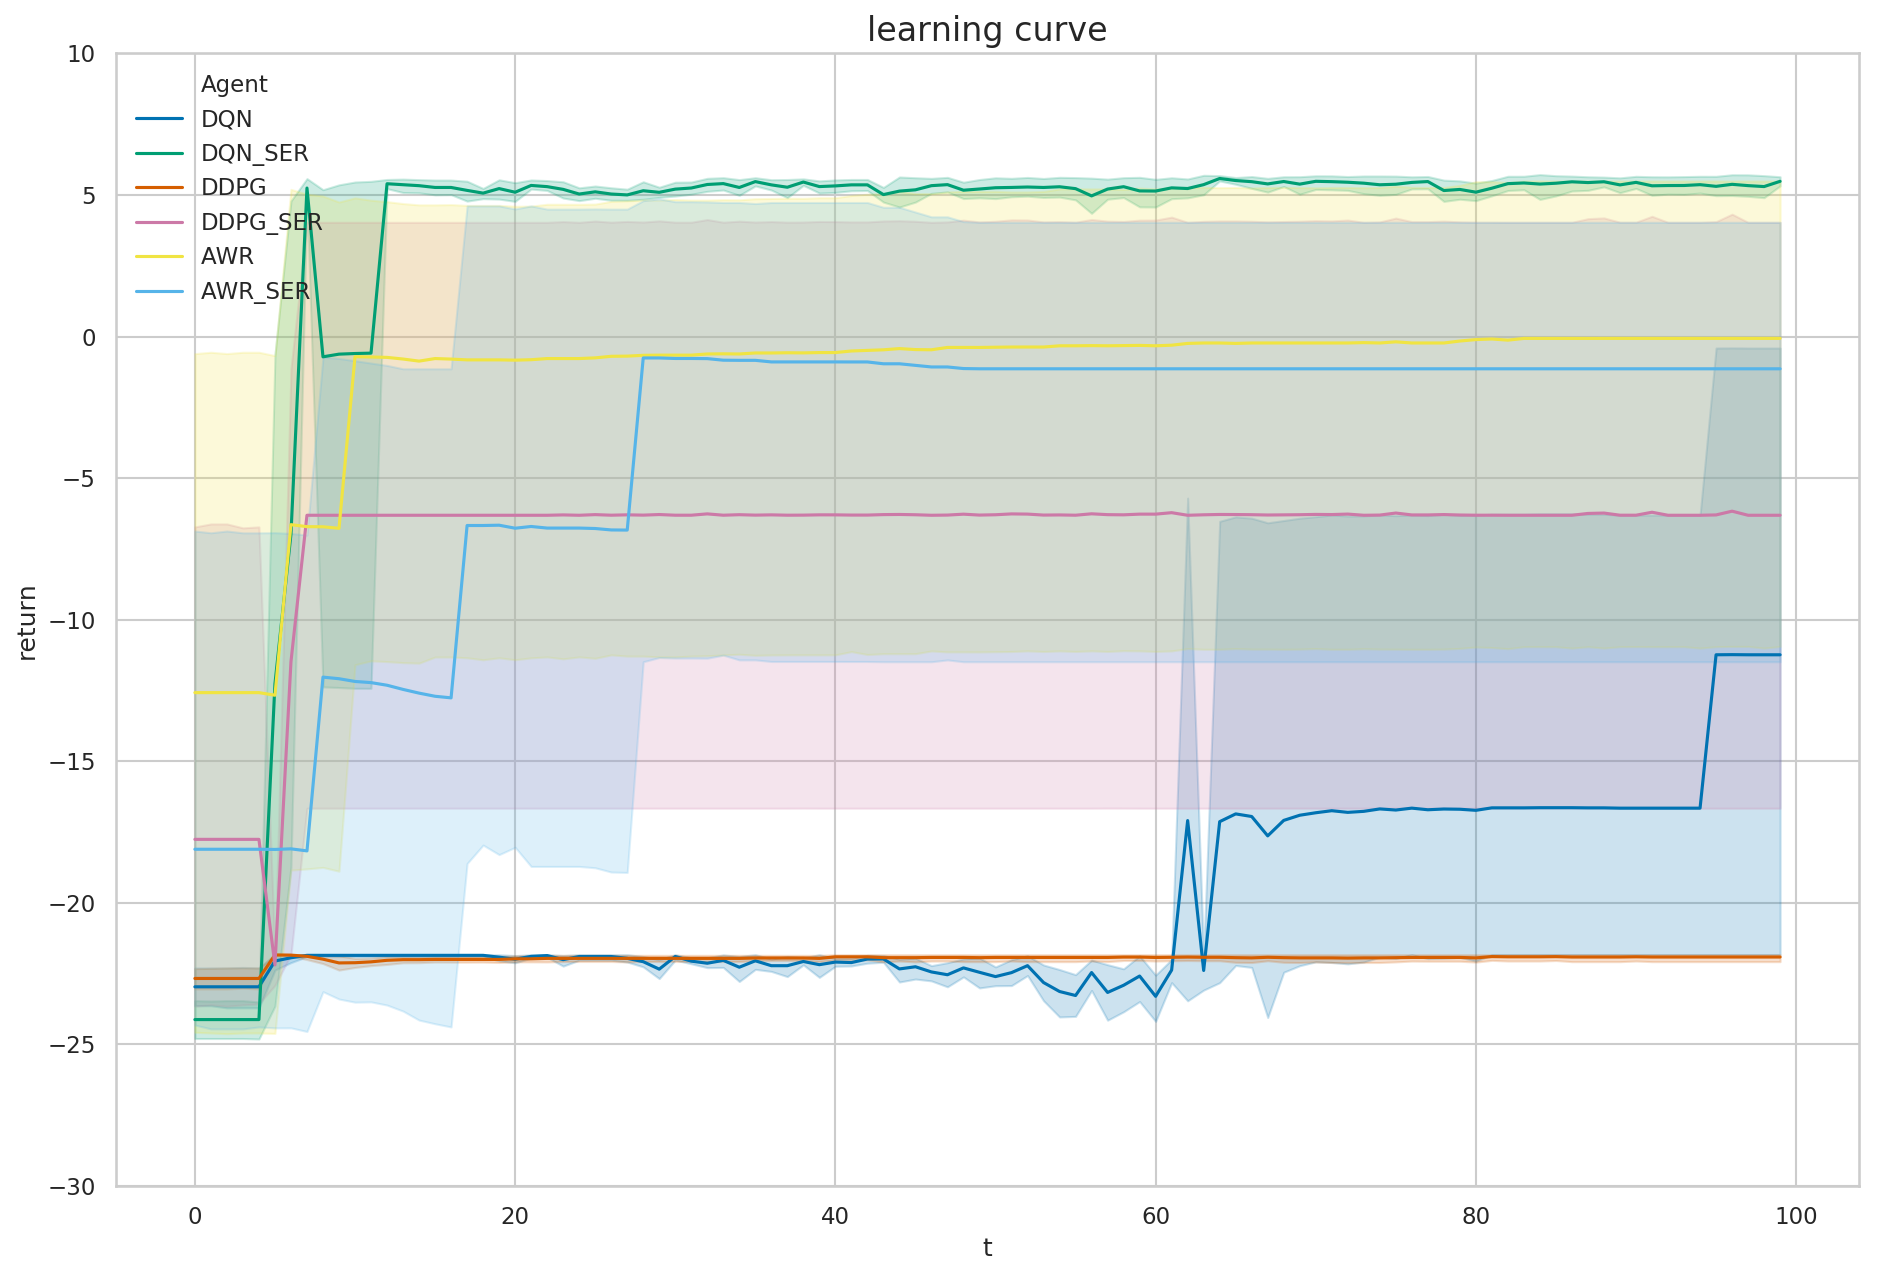

In [14]:
fig = plt.figure(figsize=(15, 10), dpi=150)
sns.lineplot(x='t', y='return', hue='Agent', data=df)
plt.ylim(-30, 10)
plt.title('learning curve', size=16)
plt.show()